# Data Science Job Change Prediction
- Author: Le Liu
- Course: COMP3010J Machine Learning


## 1. Project Overview

This project aims to predict whether a candidate is looking for a job change based on various demographic and professional features. Then infer the key factors influencing their decision.

**Dataset:** `data-science-job-change.csv`

**Problem Type:** Binary Classification

**Target Variable:** `target` (1.0 = Looking for job change, 0.0 = Not looking for job change)



*Project Structure*

1. **Introduction** - Project overview and objectives
2. **Load and Analyse Data** - Data loading and initial exploration
3. **Data Cleaning** - Handle missing values and data quality issues
4. **Data Visualisation** - Exploratory data analysis with plots
5. **Attribute Selection** - Feature selection and engineering
6. **Model Selection and Experiments** - Train and compare models
7. **Final Model Training** - Train the best model
8. **Further Analysis and Discussion** - Model interpretation
9. **Discussion** - Conclusions and future work

---
## 2. Data Loading & Analysis

In [155]:
# Load the dataset
import pandas as pd


df = pd.read_csv('data-science-job-change.csv')

# Display basic information
print(f"Dataset shape: {df.shape}")
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")
print("\nFirst 5 rows of the dataset:")
df.head()

Dataset shape: (19158, 14)
Number of rows: 19158
Number of columns: 14

First 5 rows of the dataset:


,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [156]:
# Display statistical summary
print("Statistical Summary:")
print("="*60)
numerical_cols = ['city_development_index', 'training_hours', 'target']
df[numerical_cols].describe()

Statistical Summary:


,city_development_index,training_hours,target
count,19158.000000,19158.000000,19158.000000
mean,0.828848,65.366896,0.249348
std,0.123362,60.058462,0.432647
min,0.448000,1.000000,0.000000
25%,0.740000,23.000000,0.000000
50%,0.903000,47.000000,0.000000
75%,0.920000,88.000000,0.000000
max,0.949000,336.000000,1.000000


In [157]:
# Check missing values
missing_data = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df) * 100).round(3),
    'Data_Type': df.dtypes,
    'Unique_Values': [df[col].nunique() for col in df.columns]
})

print("Data Health Report:")
print("="*80)
print(missing_data.to_string(index=False))

Data Health Report:
                Column  Missing_Count  Missing_Percentage Data_Type  Unique_Values
           enrollee_id              0               0.000     int64          19158
                  city              0               0.000    object            123
city_development_index              0               0.000   float64             93
                gender           4508              23.531    object              3
   relevent_experience              0               0.000    object              2
   enrolled_university            386               2.015    object              3
       education_level            460               2.401    object              5
      major_discipline           2813              14.683    object              6
            experience             65               0.339    object             22
          company_size           5938              30.995    object              8
          company_type           6140              32.049    object

### 2.1 Target Variable Analysis (Class Balance Check)

TARGET VARIABLE ANALYSIS: 'target' (Job Change Intention)

Class Distribution:
--------------------------------------------------
  Class 0 (Not Looking for Change   ): 14,381 (75.07%)
  Class 1 (Looking for Change       ):  4,777 (24.93%)

Imbalance Ratio: 3.01:1


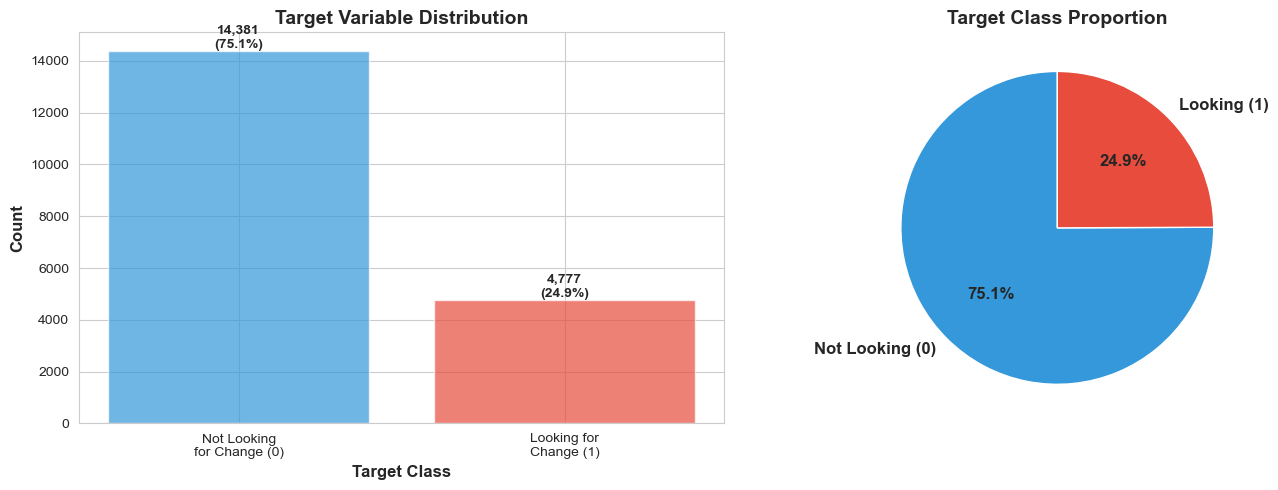

In [158]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Target variable analysis
print("=" * 80)
print("TARGET VARIABLE ANALYSIS: 'target' (Job Change Intention)")
print("=" * 80)

target_counts = df['target'].value_counts().sort_index()
target_pct = df['target'].value_counts(normalize=True).sort_index() * 100

print("\nClass Distribution:")
print("-" * 50)
for val, count, pct in zip(target_counts.index, target_counts.values, target_pct.values):
    label = "Not Looking for Change" if val == 0.0 else "Looking for Change"
    print(f"  Class {int(val)} ({label:25s}): {count:>6,} ({pct:>5.2f}%)")

# Calculate imbalance ratio
imbalance_ratio = target_counts.max() / target_counts.min()
print(f"\nImbalance Ratio: {imbalance_ratio:.2f}:1")


# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
axes[0].bar(target_counts.index, target_counts.values, color=['#3498db', '#e74c3c'], alpha=0.7)
axes[0].set_xlabel('Target Class', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Count', fontsize=12, fontweight='bold')
axes[0].set_title('Target Variable Distribution', fontsize=14, fontweight='bold')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Not Looking\nfor Change (0)', 'Looking for\nChange (1)'])
for i, (val, count) in enumerate(zip(target_counts.index, target_counts.values)):
    axes[0].text(i, count, f'{count:,}\n({target_pct.values[i]:.1f}%)', 
                 ha='center', va='bottom', fontweight='bold')

# Pie chart
colors = ['#3498db', '#e74c3c']
axes[1].pie(target_counts.values, labels=['Not Looking (0)', 'Looking (1)'], 
           autopct='%1.1f%%', colors=colors, startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'})
axes[1].set_title('Target Class Proportion', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "=" * 80)

### 2.2 Numerical Features Analysis

NUMERICAL FEATURES ANALYSIS

Feature: 'city_development_index'
------------------------------------------------------------
   Count:        19,158
   Mean:         0.8288
   Median:       0.9030
   Std Dev:      0.1234
   Min:          0.4480
   Max:          0.9490
   Range:        0.5010
   Value Range: [0.4479999999999999, 0.949]

   Skewness:    -0.9953  Left-skewed / Negative skew)
   Kurtosis:    -0.5387  (Normal tail)

   Outliers:         17 (0.09%)
   IQR Range: [0.4700, 1.1900]

Feature: 'training_hours'
------------------------------------------------------------
   Count:        19,158
   Mean:        65.3669
   Median:      47.0000
   Std Dev:     60.0585
   Min:          1.0000
   Max:        336.0000
   Range:      335.0000
   Value Range: [1, 336]

   Skewness:     1.8191  (Right-skewed / Positive skew)
   Kurtosis:     3.8392  (Heavy-tailed / Outliers present)

   Outliers:        984 (5.14%)
   IQR Range: [-74.5000, 185.5000]



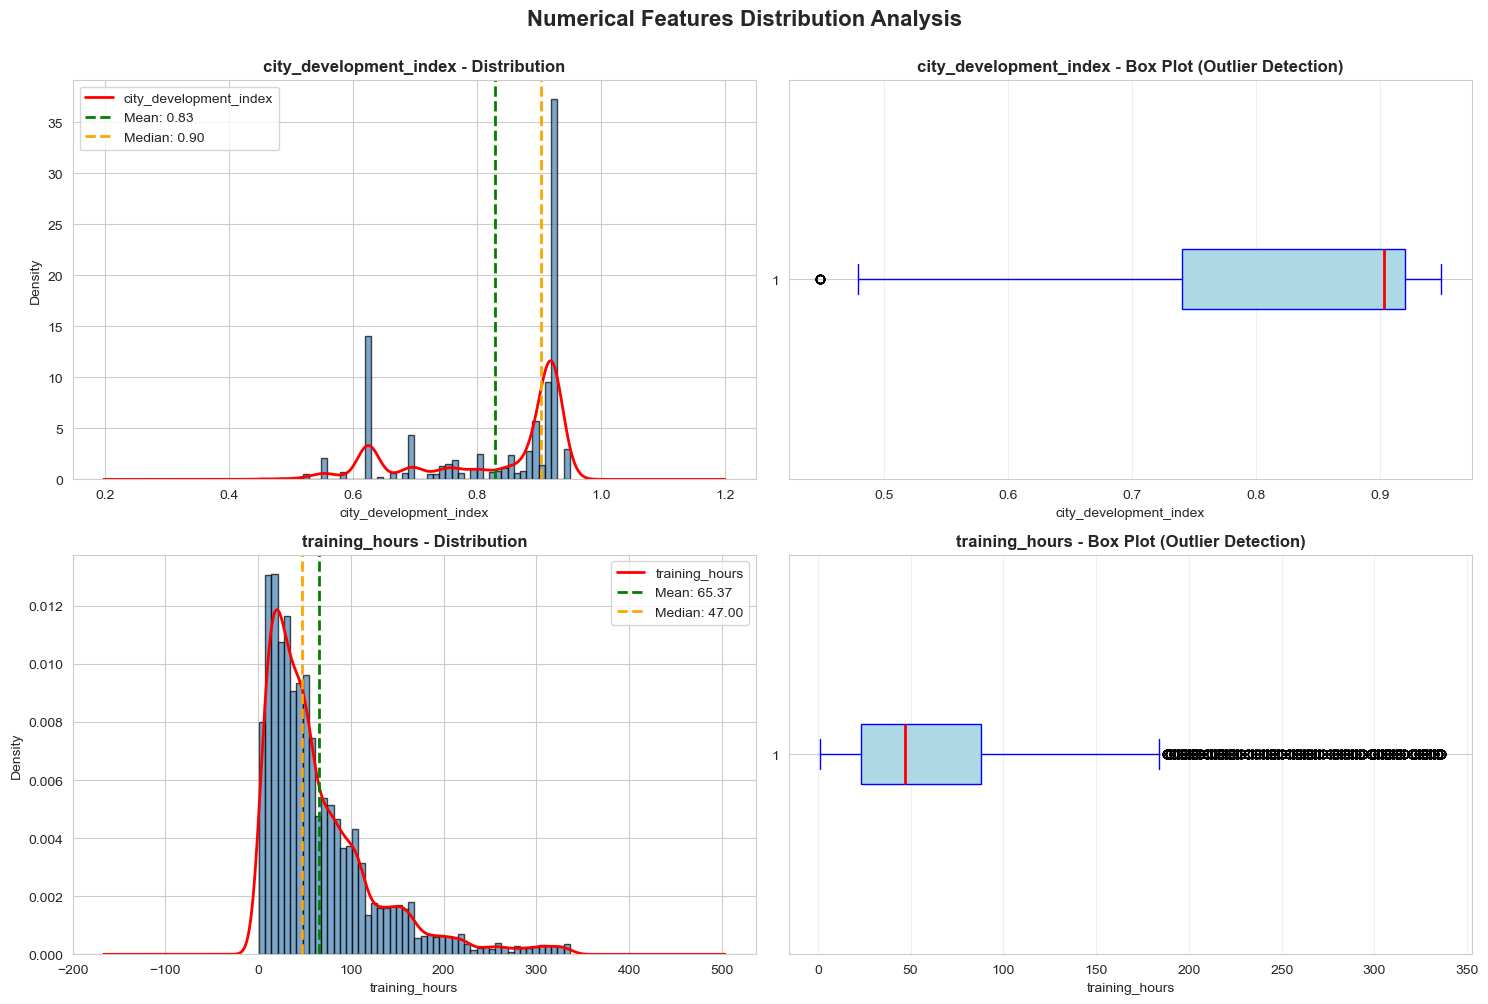

In [159]:
from scipy import stats

# Select numerical features
numerical_features = ['city_development_index', 'training_hours']

print("=" * 80)
print("NUMERICAL FEATURES ANALYSIS")
print("=" * 80)

# Detailed statistics for each numerical feature
for col in numerical_features:
    print(f"\nFeature: '{col}'")
    print("-" * 60)
    
    data = df[col].dropna()
    
    # Basic statistics
    print(f"   Count:    {len(data):>10,}")
    print(f"   Mean:     {data.mean():>10.4f}")
    print(f"   Median:   {data.median():>10.4f}")
    print(f"   Std Dev:  {data.std():>10.4f}")
    print(f"   Min:      {data.min():>10.4f}")
    print(f"   Max:      {data.max():>10.4f}")
    print(f"   Range:    {data.max() - data.min():>10.4f}")
    print(f"   Value Range: [{data.min()}, {data.max()}]")
    
    # Distribution shape
    skewness = stats.skew(data)
    kurtosis = stats.kurtosis(data)
    print(f"\n   Skewness: {skewness:>10.4f}  ", end="")
    if abs(skewness) < 0.5:
        print("(Nearly symmetric)")
    elif skewness > 0:
        print("(Right-skewed / Positive skew)")
    else:
        print("Left-skewed / Negative skew)")
    
    print(f"   Kurtosis: {kurtosis:>10.4f}  ", end="")
    if abs(kurtosis) < 1:
        print("(Normal tail)")
    elif kurtosis > 0:
        print("(Heavy-tailed / Outliers present)")
    else:
        print("(Light-tailed)")
    
    # Outlier detection (IQR method)
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    
    print(f"\n   Outliers: {len(outliers):>10,} ({len(outliers)/len(data)*100:.2f}%)")
    print(f"   IQR Range: [{lower_bound:.4f}, {upper_bound:.4f}]")

print("\n" + "=" * 80)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Numerical Features Distribution Analysis', fontsize=16, fontweight='bold', y=1.00)

for idx, col in enumerate(numerical_features):
    data = df[col].dropna()
    
    # Histogram with KDE
    axes[idx, 0].hist(data, bins=50, edgecolor='black', alpha=0.7, color='steelblue', density=True)
    data.plot(kind='kde', ax=axes[idx, 0], color='red', linewidth=2)
    axes[idx, 0].set_title(f'{col} - Distribution', fontweight='bold')
    axes[idx, 0].set_xlabel(col)
    axes[idx, 0].set_ylabel('Density')
    axes[idx, 0].axvline(data.mean(), color='green', linestyle='--', linewidth=2, label=f'Mean: {data.mean():.2f}')
    axes[idx, 0].axvline(data.median(), color='orange', linestyle='--', linewidth=2, label=f'Median: {data.median():.2f}')
    axes[idx, 0].legend()
    
    # Box plot
    axes[idx, 1].boxplot(data, vert=False, patch_artist=True,
                        boxprops=dict(facecolor='lightblue', color='blue'),
                        medianprops=dict(color='red', linewidth=2),
                        whiskerprops=dict(color='blue'),
                        capprops=dict(color='blue'))
    axes[idx, 1].set_title(f'{col} - Box Plot (Outlier Detection)', fontweight='bold')
    axes[idx, 1].set_xlabel(col)
    axes[idx, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

### 2.3 Categorical Features

In [160]:
# Categorical features
categorical_features = ['city', 'gender', 'relevent_experience', 'enrolled_university', 
                        'education_level', 'major_discipline', 'experience', 
                        'company_size', 'company_type', 'last_new_job']

print("=" * 80)
print("CATEGORICAL FEATURES - UNIQUE VALUES OVERVIEW")
print("=" * 80)

cat_summary = []
for col in categorical_features:
    n_unique = df[col].nunique()
    n_missing = df[col].isnull().sum()
    missing_pct = (n_missing / len(df)) * 100
    
    cat_summary.append({
        'Feature': col,
        'Unique_Values': n_unique,
        'Missing_Count': n_missing,
        'Missing_%': f"{missing_pct:.1f}%"
    })

cat_df = pd.DataFrame(cat_summary)
print("\n" + cat_df.to_string(index=False))

# Detailed display for features with reasonable number of categories (exclude 'city')
print("\n" + "=" * 80)
print("DETAILED VALUES FOR EACH FEATURE (excluding high-cardinality features)")
print("=" * 80)

for col in categorical_features:
    n_unique = df[col].nunique()
    
    # Skip features with too many unique values (like 'city' with 123 values)
    if n_unique > 25:
        print(f"\n Feature: '{col}'")
        print(f"   Unique Values: {n_unique} (too many to display)")
        print(f"   Note: High cardinality feature - will use Target Encoding")
        continue
    
    # Display all unique values for features with reasonable cardinality
    print(f"Feature: '{col}'")
    print(f"   Unique Values: {n_unique}")
    
    # Get value counts including missing
    value_counts = df[col].value_counts(dropna=False)
    
    print(f"   All Values: ", end="")
    all_values = df[col].dropna().unique().tolist()
    
    if n_unique <= 10:
        # For features with ≤10 values, display vertically with counts
        print()
        for val in sorted([str(v) for v in all_values]):
            count = value_counts.get(val, 0)
            pct = (count / len(df)) * 100
            print(f"      • {val:30s}  ({count:>6,} samples, {pct:>5.2f}%)")
        
        # Show missing values if any
        missing_count = df[col].isnull().sum()
        if missing_count > 0:
            print(f"      • [MISSING]                       ({missing_count:>6,} samples, {missing_count/len(df)*100:>5.2f}%)")
    else:
        # For features with 11-25 values, display horizontally 
        print(f"{sorted([str(v) for v in all_values])}")

print("\n" + "=" * 80)

CATEGORICAL FEATURES - UNIQUE VALUES OVERVIEW

            Feature  Unique_Values  Missing_Count Missing_%
               city            123              0      0.0%
             gender              3           4508     23.5%
relevent_experience              2              0      0.0%
enrolled_university              3            386      2.0%
    education_level              5            460      2.4%
   major_discipline              6           2813     14.7%
         experience             22             65      0.3%
       company_size              8           5938     31.0%
       company_type              6           6140     32.0%
       last_new_job              6            423      2.2%

DETAILED VALUES FOR EACH FEATURE (excluding high-cardinality features)

 Feature: 'city'
   Unique Values: 123 (too many to display)
   Note: High cardinality feature - will use Target Encoding
Feature: 'gender'
   Unique Values: 3
   All Values: 
      • Female                          ( 1,

### 2.4 High-Priority Categorical Features - Detailed Analysis

In [161]:
# Analyze high-priority categorical features in detail
high_priority_features = ['gender', 'company_size', 'company_type', 'major_discipline', 'experience']

print("=" * 80)
print("HIGH-PRIORITY CATEGORICAL FEATURES - DETAILED FREQUENCY ANALYSIS")
print("=" * 80)

for col in high_priority_features:
    print(f"\n{'=' * 80}")
    print(f"Feature: '{col}'")
    print(f"{'=' * 80}")
    
    # Value counts
    value_counts = df[col].value_counts(dropna=False)
    value_pcts = df[col].value_counts(normalize=True, dropna=False) * 100
    
    # Create summary table
    summary_df = pd.DataFrame({
        'Value': value_counts.index,
        'Count': value_counts.values,
        'Percentage': [f"{pct:.2f}%" for pct in value_pcts.values]
    })
    
    print(f"\n   Total Unique Values: {df[col].nunique()}")
    print(f"   Missing Values: {df[col].isnull().sum()} ({df[col].isnull().sum()/len(df)*100:.2f}%)")
    print(f"\n   Frequency Distribution:")
    print("   " + "-" * 70)
    
    # Display top 15 values (or all if less than 15)
    display_limit = min(15, len(summary_df))
    for idx, row in summary_df.head(display_limit).iterrows():
        val_str = str(row['Value']) if pd.notna(row['Value']) else '**MISSING**'
        print(f"   {val_str:30s} {row['Count']:>8,}   ({row['Percentage']:>7s})")
    
    if len(summary_df) > display_limit:
        print(f"   ... ({len(summary_df) - display_limit} more values)")
    
    # Identify rare categories (< 1% of data)
    rare_cats = value_pcts[value_pcts < 1.0]
    if len(rare_cats) > 0:
        print(f"\n   ⚠️  Rare categories (< 1%): {len(rare_cats)} values")
        print(f"      Consider combining or special handling")

print("\n" + "=" * 80)

HIGH-PRIORITY CATEGORICAL FEATURES - DETAILED FREQUENCY ANALYSIS

Feature: 'gender'

   Total Unique Values: 3
   Missing Values: 4508 (23.53%)

   Frequency Distribution:
   ----------------------------------------------------------------------
   Male                             13,221   ( 69.01%)
   **MISSING**                       4,508   ( 23.53%)
   Female                            1,238   (  6.46%)
   Other                               191   (  1.00%)

   ⚠️  Rare categories (< 1%): 1 values
      Consider combining or special handling

Feature: 'company_size'

   Total Unique Values: 8
   Missing Values: 5938 (30.99%)

   Frequency Distribution:
   ----------------------------------------------------------------------
   **MISSING**                       5,938   ( 30.99%)
   50-99                             3,083   ( 16.09%)
   100-500                           2,571   ( 13.42%)
   10000+                            2,019   ( 10.54%)
   10/49                             1,47

### 2.5 Feature vs Target - Relationship Analysis

In [162]:
# Analyze key features' relationship with target variable
key_features = ['relevent_experience', 'company_size', 'company_type', 'education_level']

print("=" * 80)
print("FEATURE vs TARGET RELATIONSHIP ANALYSIS")
print("=" * 80)

for col in key_features:
    print(f"\n{'=' * 80}")
    print(f"Feature: '{col}' vs Target (Job Change Intention)")
    print(f"{'=' * 80}")
    
    # Create crosstab without margins first
    crosstab = pd.crosstab(df[col], df['target'], dropna=False)
    
    # Calculate percentages (target=1 rate for each category)
    target_rate = pd.crosstab(df[col], df['target'], normalize='index', dropna=False)
    
    # Combine into summary
    summary_data = []
    for cat in crosstab.index:
        total = crosstab.loc[cat].sum()
        target_0 = crosstab.loc[cat, 0.0] if 0.0 in crosstab.columns else 0
        target_1 = crosstab.loc[cat, 1.0] if 1.0 in crosstab.columns else 0
        rate_1 = target_rate.loc[cat, 1.0] * 100 if 1.0 in target_rate.columns else 0
        
        summary_data.append({
            'Category': cat,
            'Total_Count': int(total),
            'Target=0': int(target_0),
            'Target=1': int(target_1),
            'Target=1_Rate': f"{rate_1:.2f}%"
        })
    
    summary = pd.DataFrame(summary_data)
    print("\n" + summary.to_string(index=False))
    
    # Highlight significant differences
    rates = [float(row['Target=1_Rate'].rstrip('%')) for row in summary_data]
    avg_rate = np.mean(rates)
    print(f"\n   Average Target=1 Rate: {avg_rate:.2f}%")
    
    high_rate = [row['Category'] for row, rate in zip(summary_data, rates) if rate > avg_rate + 5]
    low_rate = [row['Category'] for row, rate in zip(summary_data, rates) if rate < avg_rate - 5]
    
    if high_rate:
        print(f"Higher likelihood of job change: {high_rate}")
    if low_rate:
        print(f"Lower likelihood of job change: {low_rate}")

print("\n" + "=" * 80)

FEATURE vs TARGET RELATIONSHIP ANALYSIS

Feature: 'relevent_experience' vs Target (Job Change Intention)

               Category  Total_Count  Target=0  Target=1 Target=1_Rate
Has relevent experience        13792     10831      2961        21.47%
 No relevent experience         5366      3550      1816        33.84%

   Average Target=1 Rate: 27.66%
Higher likelihood of job change: ['No relevent experience']
Lower likelihood of job change: ['Has relevent experience']

Feature: 'company_size' vs Target (Job Change Intention)

 Category  Total_Count  Target=0  Target=1 Target=1_Rate
    10/49         1471      1127       344        23.39%
  100-500         2571      2156       415        16.14%
1000-4999         1328      1128       200        15.06%
   10000+         2019      1634       385        19.07%
    50-99         3083      2538       545        17.68%
  500-999          877       725       152        17.33%
5000-9999          563       461       102        18.12%
      <10   

### 2.6 Data Quality Checks

In [163]:
print("=" * 80)
print("DATA QUALITY CHECKS")
print("=" * 80)

# 1. Duplicate rows check
duplicate_count = df.duplicated().sum()
print(f"Duplicate Rows: {duplicate_count}")
if duplicate_count > 0:
    print(f"Found {duplicate_count} duplicate rows")
    print(f"Action: Review and consider removing duplicates")
else:
    print("No duplicate rows found")

# 2. Duplicate enrollee_id check
duplicate_ids = df['enrollee_id'].duplicated().sum()
print(f"Duplicate Enrollee IDs: {duplicate_ids}")
if duplicate_ids > 0:
    print(f"Found {duplicate_ids} duplicate IDs - possible data entry errors")
else:
    print("All enrollee IDs are unique")
print("\n" + "=" * 80)

DATA QUALITY CHECKS
Duplicate Rows: 0
No duplicate rows found
Duplicate Enrollee IDs: 0
All enrollee IDs are unique



### 2.8 Summary of Data Analysis Findings

**Key Insights from Exploratory Data Analysis:**

**Target Variable**
- Check class balance and imbalance ratio
- Determine if sampling/weighting strategies are needed

**Numerical Features (2 features)**
- **Distribution shape**: Skewness & Kurtosis analysis
- **Outlier detection**: IQR method for anomaly identification
- **Statistical summary**: Mean, median, std, range

**Categorical Features (10 features)**
- **Unique values count**: Understanding cardinality
- **Missing data**: Identify features requiring imputation
- **Frequency distribution**: Find rare/dominant categories
- **Feature-Target relationship**: Identify predictive patterns

**Data Quality**
- Duplicate records check
- ID uniqueness validation
- Format consistency (e.g., `company_size` "10/49" issue)
- Range validation for numerical features

---

**Next Steps:** Based on findings, proceed to Data Visualisation and then Data Cleaning (Section 3)

### 2.9 Key Data Visualisations

In this section, we visualize the relationships between key features and the target variable to gain insights into what factors influence job change decisions.

**Visualisation Strategy:**
1. **Categorical Features vs Target** - Compare job change rates across categories
2. **Numerical Features Distribution** - Compare distributions between two target classes
3. **Key Insights** - Summarize findings from visualisations

In [164]:
# Prepare data for visualization
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 12)

print("="*80)
print("DATA VISUALISATION: Feature Relationships with Target Variable")
print("="*80)

DATA VISUALISATION: Feature Relationships with Target Variable


#### Visualisation 1: Key Categorical Features vs Job Change Rate

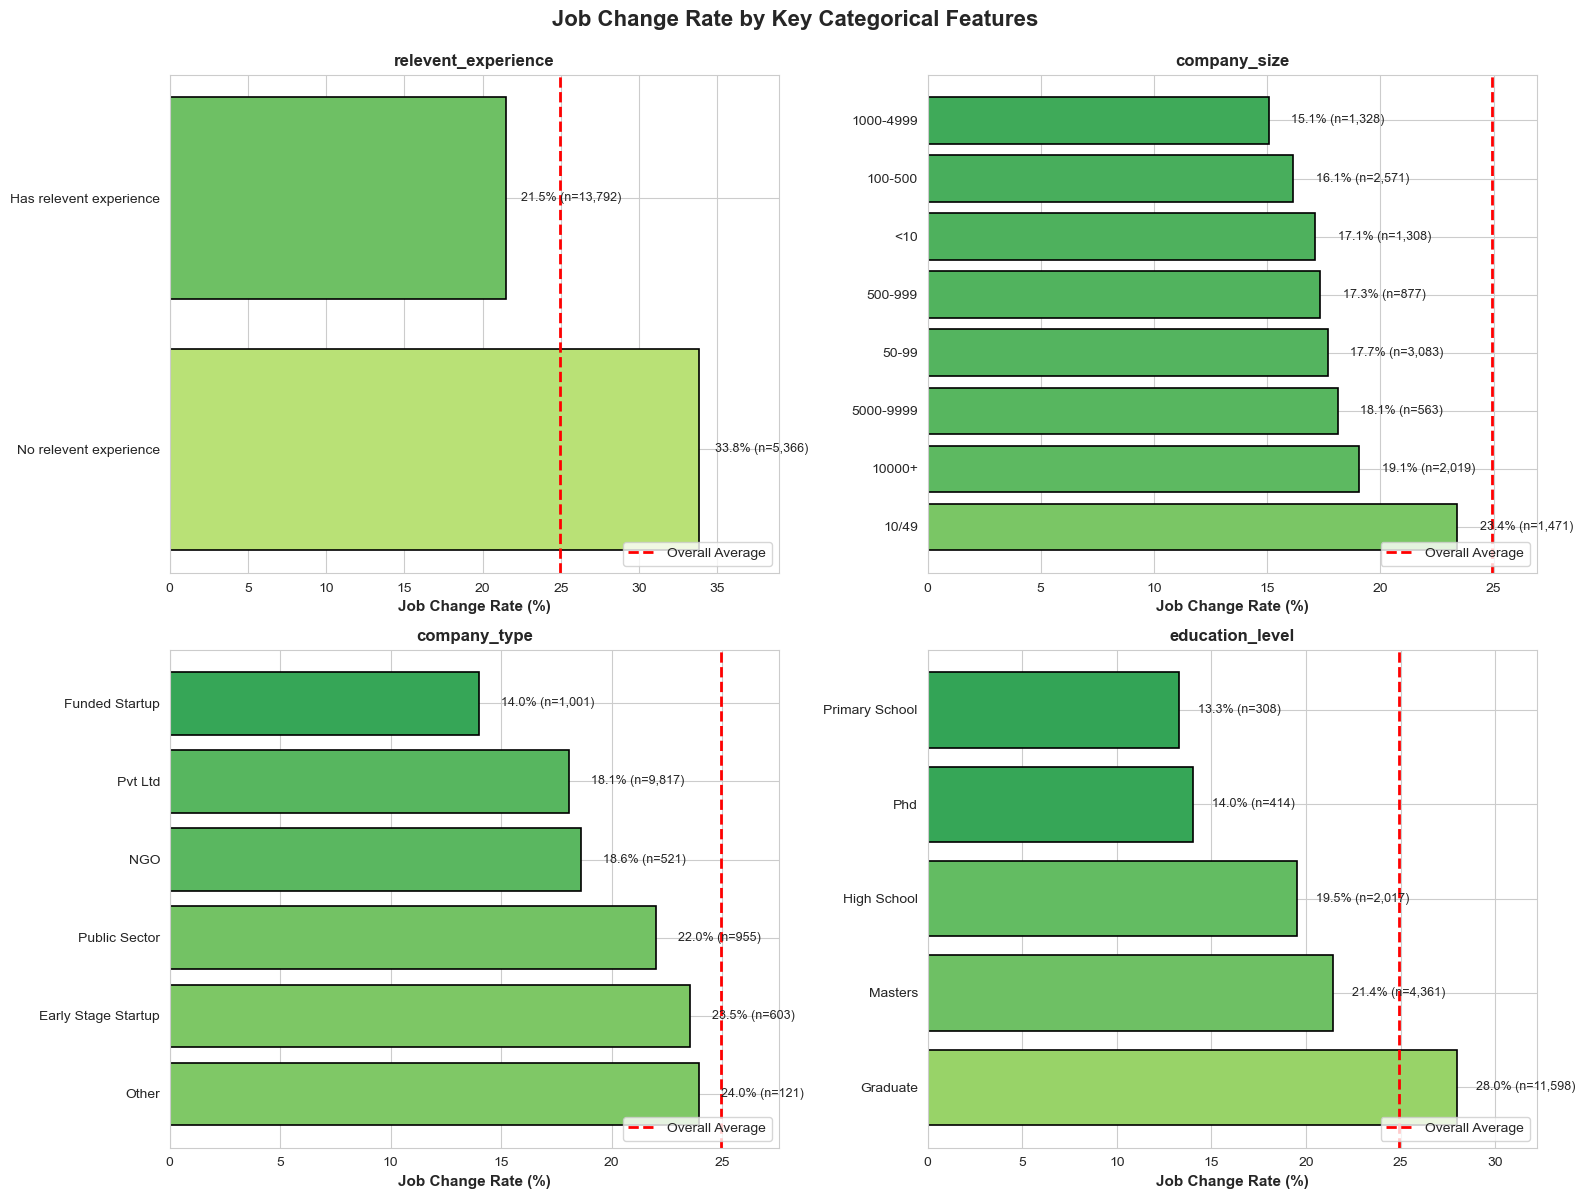


Key Observations:
--------------------------------------------------------------------------------
1. Relevant Experience: Candidates WITH relevant experience have LOWER job change rates
2. Company Size: Smaller companies (<10) show higher job change tendency
3. Company Type: Pvt Ltd companies have highest retention (lowest change rate)
4. Education Level: Graduate level shows balanced job change behavior


In [165]:
# Select key categorical features for visualization
key_cat_features = ['relevent_experience', 'company_size', 'company_type', 'education_level']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Job Change Rate by Key Categorical Features', fontsize=16, fontweight='bold', y=0.995)

for idx, feature in enumerate(key_cat_features):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]
    
    # Calculate target rate for each category
    crosstab = pd.crosstab(df[feature], df['target'])
    target_rate = (crosstab[1.0] / crosstab.sum(axis=1) * 100).sort_values(ascending=False)
    
    # Create bar plot
    colors = plt.cm.RdYlGn_r(target_rate / 100)
    bars = ax.barh(range(len(target_rate)), target_rate.values, color=colors, edgecolor='black', linewidth=1.2)
    
    # Customize plot
    ax.set_yticks(range(len(target_rate)))
    ax.set_yticklabels(target_rate.index, fontsize=10)
    ax.set_xlabel('Job Change Rate (%)', fontsize=11, fontweight='bold')
    ax.set_title(f'{feature}', fontsize=12, fontweight='bold')
    ax.axvline(df['target'].mean() * 100, color='red', linestyle='--', linewidth=2, label='Overall Average')
    
    # Add value labels
    for i, (v, count) in enumerate(zip(target_rate.values, crosstab.sum(axis=1)[target_rate.index])):
        ax.text(v + 1, i, f'{v:.1f}% (n={count:,})', va='center', fontsize=9)
    
    ax.legend(loc='lower right')
    ax.set_xlim(0, max(target_rate.values) * 1.15)

plt.tight_layout()
plt.show()

print("\nKey Observations:")
print("-" * 80)
print("1. Relevant Experience: Candidates WITH relevant experience have LOWER job change rates")
print("2. Company Size: Smaller companies (<10) show higher job change tendency")
print("3. Company Type: Pvt Ltd companies have highest retention (lowest change rate)")
print("4. Education Level: Graduate level shows balanced job change behavior")

#### Visualisation 2: Experience Level Distribution by Target

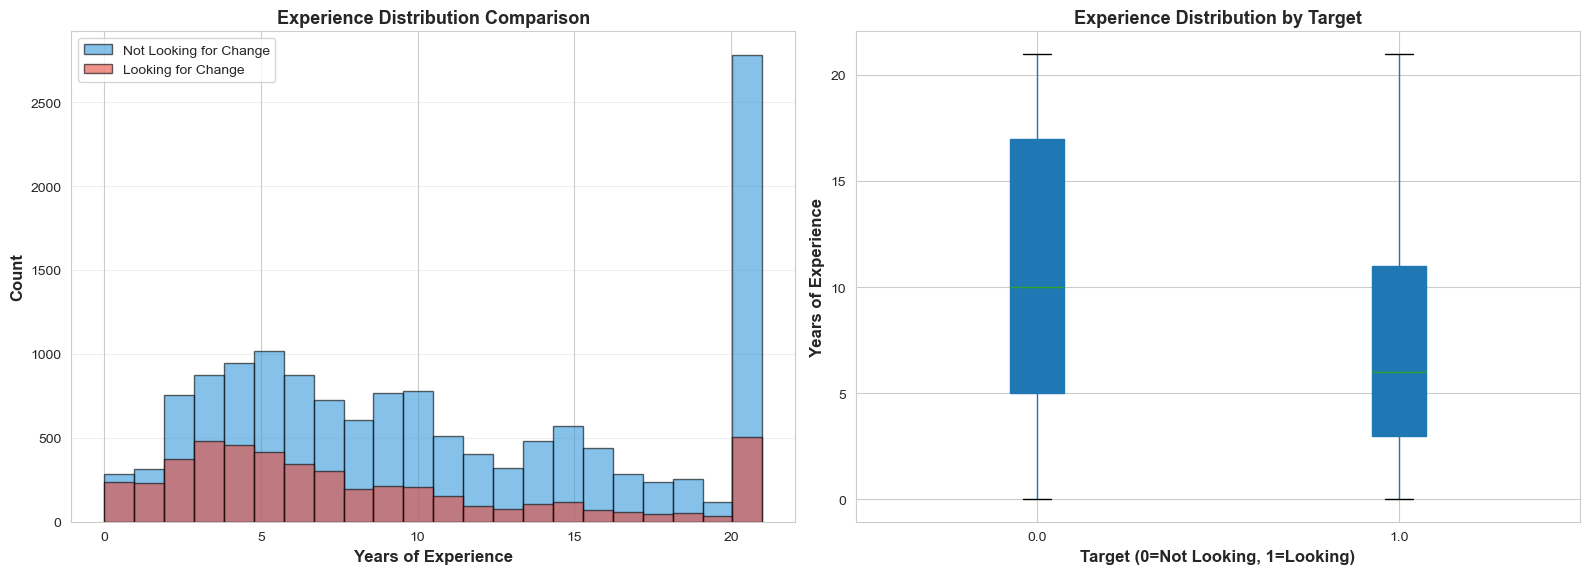


Key Observations:
--------------------------------------------------------------------------------
Average experience (Not looking for change): 10.79 years
Average experience (Looking for change):     8.02 years
Job changers tend to have slightly LOWER average experience


In [166]:
# Visualize experience distribution for both target classes
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Experience Distribution: Job Changers vs Non-Changers', fontsize=16, fontweight='bold')

# Convert experience to numeric for plotting
exp_mapping = {
    '<1': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5,
    '6': 6, '7': 7, '8': 8, '9': 9, '10': 10,
    '11': 11, '12': 12, '13': 13, '14': 14, '15': 15,
    '16': 16, '17': 17, '18': 18, '19': 19, '20': 20, '>20': 21
}

df_temp = df.copy()
df_temp['experience_numeric'] = df_temp['experience'].map(exp_mapping)

# Plot 1: Histogram comparison
for target_val, color, label in [(0, '#3498db', 'Not Looking for Change'), 
                                   (1, '#e74c3c', 'Looking for Change')]:
    data = df_temp[df_temp['target'] == target_val]['experience_numeric'].dropna()
    axes[0].hist(data, bins=22, alpha=0.6, label=label, color=color, edgecolor='black')

axes[0].set_xlabel('Years of Experience', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Count', fontsize=12, fontweight='bold')
axes[0].set_title('Experience Distribution Comparison', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Plot 2: Box plot comparison
df_temp.boxplot(column='experience_numeric', by='target', ax=axes[1], patch_artist=True)
axes[1].set_xlabel('Target (0=Not Looking, 1=Looking)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Years of Experience', fontsize=12, fontweight='bold')
axes[1].set_title('Experience Distribution by Target', fontsize=13, fontweight='bold')
plt.suptitle('')  # Remove default title

plt.tight_layout()
plt.show()

print("\nKey Observations:")
print("-" * 80)
print(f"Average experience (Not looking for change): {df_temp[df_temp['target']==0]['experience_numeric'].mean():.2f} years")
print(f"Average experience (Looking for change):     {df_temp[df_temp['target']==1]['experience_numeric'].mean():.2f} years")
print("Job changers tend to have slightly LOWER average experience")

#### Visualisation 3: Training Hours and City Development Index

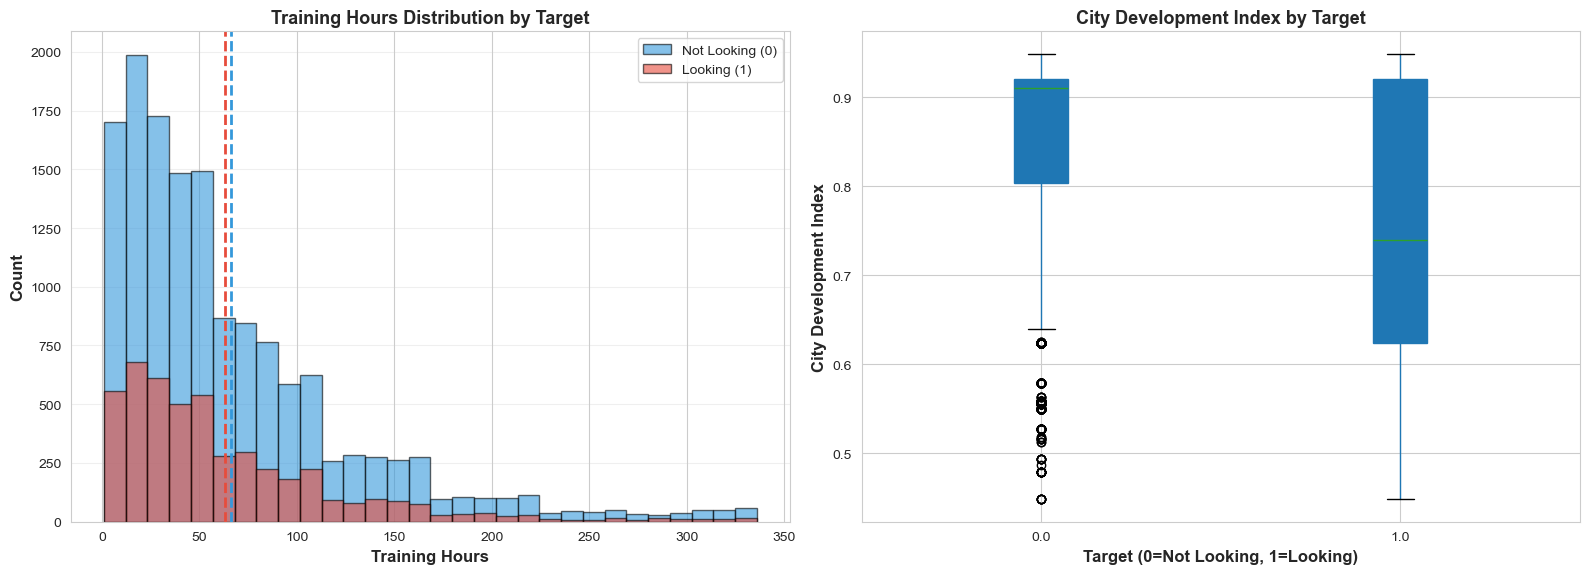


Key Observations:
--------------------------------------------------------------------------------
Average training hours (Not looking): 66.1 hours
Average training hours (Looking):     63.1 hours
Average CDI (Not looking): 0.853
Average CDI (Looking):     0.756

Candidates in MORE developed cities are LESS likely to change jobs


In [167]:
# Visualize numerical features
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Numerical Features: Training Hours & City Development Index', fontsize=16, fontweight='bold')

# Plot 1: Training Hours by Target
for target_val, color, label in [(0, '#3498db', 'Not Looking (0)'), 
                                   (1, '#e74c3c', 'Looking (1)')]:
    data = df[df['target'] == target_val]['training_hours']
    axes[0].hist(data, bins=30, alpha=0.6, label=label, color=color, edgecolor='black')

axes[0].set_xlabel('Training Hours', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Count', fontsize=12, fontweight='bold')
axes[0].set_title('Training Hours Distribution by Target', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].axvline(df[df['target']==0]['training_hours'].mean(), color='#3498db', linestyle='--', linewidth=2, label='Mean (0)')
axes[0].axvline(df[df['target']==1]['training_hours'].mean(), color='#e74c3c', linestyle='--', linewidth=2, label='Mean (1)')
axes[0].grid(axis='y', alpha=0.3)

# Plot 2: City Development Index by Target
df.boxplot(column='city_development_index', by='target', ax=axes[1], patch_artist=True)
axes[1].set_xlabel('Target (0=Not Looking, 1=Looking)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('City Development Index', fontsize=12, fontweight='bold')
axes[1].set_title('City Development Index by Target', fontsize=13, fontweight='bold')
plt.suptitle('')

plt.tight_layout()
plt.show()

print("\nKey Observations:")
print("-" * 80)
print(f"Average training hours (Not looking): {df[df['target']==0]['training_hours'].mean():.1f} hours")
print(f"Average training hours (Looking):     {df[df['target']==1]['training_hours'].mean():.1f} hours")
print(f"Average CDI (Not looking): {df[df['target']==0]['city_development_index'].mean():.3f}")
print(f"Average CDI (Looking):     {df[df['target']==1]['city_development_index'].mean():.3f}")
print("\nCandidates in MORE developed cities are LESS likely to change jobs")

#### Summary of Visualisation Insights

**Key Findings:**

1. **Relevant Experience Impact**
   - Candidates WITHOUT relevant experience are MORE likely to seek job changes
   - This suggests career dissatisfaction or seeking better fit

2. **Company Size Effect**
   - Smaller companies (<10 employees) have higher turnover rates
   - Larger companies (1000+) show better retention

3. **Experience Level Paradox**
   - Job changers have slightly LOWER average experience
   - Mid-career professionals (5-10 years) show highest mobility

4. **City Development Factor**
   - Candidates in less developed cities are MORE likely to change jobs
   - Economic opportunities may drive this pattern

5. **Training Hours**
   - Similar training hours across both groups
   - Training alone doesn't predict job change behavior

**Implications for Modeling:**
- `relevent_experience`, `company_size`, and `city_development_index` are likely strong predictors
- `experience` shows non-linear relationship (requires careful feature engineering)
- `training_hours` may be less predictive (but still worth including)

---

---

##  3. Data Cleaning & Feature Engineering Strategy

Based on the comprehensive data analysis above, here is the detailed processing strategy for each of the 14 features:

###  3.1 Strategy Overview Table

| # | Feature | Type | Action | Priority | Reason |
|---|---------|------|--------|----------|--------|
| 1 | `enrollee_id` | ID | **DELETE** | 🔴 High | No predictive value - just an identifier |
| 2 | `city` | Categorical (123 values) | **Target Encoding** | 🟡 Medium | Too many categories for One-Hot |
| 3 | `city_development_index` | Numerical | **Keep as-is** | 🟢 Low | Already numeric, no missing values |
| 4 | `gender` | Categorical (3 values) | **Fill Missing + One-Hot** | 🟡 Medium | 23% missing, create "Unknown" category |
| 5 | `relevent_experience` | Binary | **Label Encoding** | 🟢 Low | No missing, convert to 0/1 |
| 6 | `enrolled_university` | Categorical (3 values) | **Fill Missing + One-Hot** | 🟢 Low | 2% missing, 3 clear categories |
| 7 | `education_level` | Ordinal (5 values) | **Ordinal Encoding** | 🟡 Medium | 2% missing, has natural order |
| 8 | `major_discipline` | Categorical (6 values) | **Fill Missing + One-Hot** | 🟡 Medium | 15% missing, may correlate with education |
| 9 | `experience` | Ordinal (22 values) | **Ordinal Encoding** | 🔴 High | Convert to numeric years (e.g., "<1"→0, ">20"→21) |
| 10 | `company_size` | Ordinal (8 values) | **Fix Format + Ordinal** | 🔴 High | 31% missing, FIX "10/49" → "10-49" |
| 11 | `company_type` | Categorical (6 values) | **Fill Missing + One-Hot** | 🟡 Medium | 32% missing, create "Unknown" |
| 12 | `last_new_job` | Ordinal (6 values) | **Ordinal Encoding** | 🟢 Low | 2% missing, convert to numeric |
| 13 | `training_hours` | Numerical | **Keep as-is** | 🟢 Low | Already numeric, no missing values |
| 14 | `target` | Binary | **Keep as-is** | N/A | Target variable - no transformation needed |

---

### 3.2 Data Clean and Base Encoding


In [168]:
# Create a copy of the original dataframe for cleaning
df_clean = df.copy()

print(f"Original dataset shape: {df_clean.shape}")
print(f"Starting data cleaning process...\n")

Original dataset shape: (19158, 14)
Starting data cleaning process...



#### 1. `enrollee_id`
Delete the column `enrollee_id` because it is not interesting for our analysis.

In [169]:
# Feature 1: enrollee_id
print("="*70)
print("Processing Feature 1: enrollee_id")
print("="*70)

missing_count = df_clean['enrollee_id'].isna().sum()
print(f"\nMissing before: {missing_count} ({missing_count/len(df_clean)*100:.2f}%)")

# Delete the column (no predictive value)
df_clean = df_clean.drop('enrollee_id', axis=1)

print(f"\nFeature 1 processed: enrollee_id")
print(f"   Action: Deleted (identifier column)")
print(f"   New shape: {df_clean.shape}")
print(f"   Columns remaining: {df_clean.shape[1]}\n")

Processing Feature 1: enrollee_id

Missing before: 0 (0.00%)

Feature 1 processed: enrollee_id
   Action: Deleted (identifier column)
   New shape: (19158, 13)
   Columns remaining: 13



#### 2. `company_size`
**Action:** Fix format error ('10/49'→'10-49'), create missing indicator, fill with median, ordinal encoding (0-7)  
**Reason:** 31% missing + format issue; ordinal relationship exists (company scale)

In [170]:
# Feature 2: company_size
print("="*70)
print("Processing Feature 2: company_size")
print("="*70)

missing_count = df_clean['company_size'].isna().sum()
print(f"\nMissing before: {missing_count} ({missing_count/len(df_clean)*100:.2f}%)")

# Step 1: Fix formatting error
print("\nStep 1: Fix formatting error '10/49' -> '10-49'")
df_clean['company_size'] = df_clean['company_size'].replace('10/49', '10-49')
print(f"   Fixed {df_clean['company_size'].value_counts().get('10-49', 0):,} instances")

# Step 2: Create missing indicator
print("\nStep 2: Create missing indicator feature")
df_clean['company_size_missing'] = df_clean['company_size'].isna().astype(int)
print(f"   Created 'company_size_missing' (1=missing, 0=known)")

# Step 3: Fill missing with median category
print("\nStep 3: Fill missing with median category")
median_category = '50-99'
df_clean['company_size'] = df_clean['company_size'].fillna(median_category)
print(f"   Filled {missing_count:,} missing values with '{median_category}'")
print(f"   Missing after: {df_clean['company_size'].isna().sum()}")

# Step 4: Ordinal encoding
print("\nStep 4: Ordinal encoding (small to large)")
size_order = {
    '<10': 0, '10-49': 1, '50-99': 2, '100-500': 3,
    '500-999': 4, '1000-4999': 5, '5000-9999': 6, '10000+': 7
}
df_clean['company_size'] = df_clean['company_size'].map(size_order)

print("   Encoding mapping:")
for key, value in size_order.items():
    count = (df_clean['company_size'] == value).sum()
    print(f"      {key:12s} -> {value}  ({count:,} samples)")

print(f"\nFeature 2 processed: company_size + company_size_missing")
print(f"   company_size: Type={df_clean['company_size'].dtype}, Range=[{df_clean['company_size'].min()}, {df_clean['company_size'].max()}]")
print(f"   company_size_missing: {df_clean['company_size_missing'].value_counts().to_dict()}")
print(f"   Shape: {df_clean.shape}\n")

Processing Feature 2: company_size

Missing before: 5938 (30.99%)

Step 1: Fix formatting error '10/49' -> '10-49'
   Fixed 1,471 instances

Step 2: Create missing indicator feature
   Created 'company_size_missing' (1=missing, 0=known)

Step 3: Fill missing with median category
   Filled 5,938 missing values with '50-99'
   Missing after: 0

Step 4: Ordinal encoding (small to large)
   Encoding mapping:
      <10          -> 0  (1,308 samples)
      10-49        -> 1  (1,471 samples)
      50-99        -> 2  (9,021 samples)
      100-500      -> 3  (2,571 samples)
      500-999      -> 4  (877 samples)
      1000-4999    -> 5  (1,328 samples)
      5000-9999    -> 6  (563 samples)
      10000+       -> 7  (2,019 samples)

Feature 2 processed: company_size + company_size_missing
   company_size: Type=int64, Range=[0, 7]
   company_size_missing: {0: 13220, 1: 5938}
   Shape: (19158, 14)



#### 3. `company_type`
**Action:** Fill missing with 'Unknown', One-Hot encoding  
**Reason:** 32% missing; 6 nominal categories (no natural order)

In [171]:
# Feature 3: company_type
print("="*70)
print("Processing Feature 3: company_type")
print("="*70)

missing_count = df_clean['company_type'].isna().sum()
print(f"\nMissing before: {missing_count} ({missing_count/len(df_clean)*100:.2f}%)")

# Step 1: Fill missing values
print("\nStep 1: Fill missing values with 'Unknown'")
df_clean['company_type'] = df_clean['company_type'].fillna('Unknown')
print(f"   Filled {missing_count:,} missing values with 'Unknown'")
print(f"   Missing after: {df_clean['company_type'].isna().sum()}")

# Step 2: One-Hot encoding
print("\nStep 2: One-Hot encoding")
print(f"   Categories: {sorted(df_clean['company_type'].unique())}")

company_type_dummies = pd.get_dummies(df_clean['company_type'], prefix='company_type', drop_first=False)
df_clean = pd.concat([df_clean, company_type_dummies], axis=1)
df_clean = df_clean.drop('company_type', axis=1)

print(f"   Created {len(company_type_dummies.columns)} binary columns:")
for col in sorted(company_type_dummies.columns):
    count = df_clean[col].sum()
    print(f"      {col:35s}: {count:,} samples")

print(f"\nFeature 3 processed: company_type")
print(f"   New columns added: {len(company_type_dummies.columns)}")
print(f"   Shape: {df_clean.shape}\n")

Processing Feature 3: company_type

Missing before: 6140 (32.05%)

Step 1: Fill missing values with 'Unknown'
   Filled 6,140 missing values with 'Unknown'
   Missing after: 0

Step 2: One-Hot encoding
   Categories: ['Early Stage Startup', 'Funded Startup', 'NGO', 'Other', 'Public Sector', 'Pvt Ltd', 'Unknown']
   Created 7 binary columns:
      company_type_Early Stage Startup   : 603 samples
      company_type_Funded Startup        : 1,001 samples
      company_type_NGO                   : 521 samples
      company_type_Other                 : 121 samples
      company_type_Public Sector         : 955 samples
      company_type_Pvt Ltd               : 9,817 samples
      company_type_Unknown               : 6,140 samples

Feature 3 processed: company_type
   New columns added: 7
   Shape: (19158, 20)



#### 4. `gender`
**Action:** Fill missing with 'Unknown', One-Hot encoding  
**Reason:** 23% missing; 3 nominal categories (Male/Female/Other)

In [172]:
# Feature 4: gender
print("="*70)
print("Processing Feature 4: gender")
print("="*70)

missing_count = df_clean['gender'].isna().sum()
print(f"\nMissing before: {missing_count} ({missing_count/len(df_clean)*100:.2f}%)")

# Step 1: Fill missing values
print("\nStep 1: Fill missing values with 'Unknown'")
df_clean['gender'] = df_clean['gender'].fillna('Unknown')
print(f"   Filled {missing_count:,} missing values with 'Unknown'")
print(f"   Missing after: {df_clean['gender'].isna().sum()}")

# Step 2: One-Hot encoding
print("\nStep 2: One-Hot encoding")
gender_dummies = pd.get_dummies(df_clean['gender'], prefix='gender', drop_first=False)
df_clean = pd.concat([df_clean, gender_dummies], axis=1)
df_clean = df_clean.drop('gender', axis=1)

print(f"   Created {len(gender_dummies.columns)} binary columns:")
for col in sorted(gender_dummies.columns):
    count = df_clean[col].sum()
    print(f"      {col:35s}: {count:,} samples")

print(f"\nFeature 4 processed: gender")
print(f"   Shape: {df_clean.shape}\n")

Processing Feature 4: gender

Missing before: 4508 (23.53%)

Step 1: Fill missing values with 'Unknown'
   Filled 4,508 missing values with 'Unknown'
   Missing after: 0

Step 2: One-Hot encoding
   Created 4 binary columns:
      gender_Female                      : 1,238 samples
      gender_Male                        : 13,221 samples
      gender_Other                       : 191 samples
      gender_Unknown                     : 4,508 samples

Feature 4 processed: gender
   Shape: (19158, 23)



#### 5. `major_discipline`
**Action:** Fill missing with 'Unknown', One-Hot encoding  
**Reason:** 15% missing; 6 nominal categories (STEM, Business, etc.)

In [173]:
# Feature 5: major_discipline
print("="*70)
print("Processing Feature 5: major_discipline")
print("="*70)

missing_count = df_clean['major_discipline'].isna().sum()
print(f"\nMissing before: {missing_count} ({missing_count/len(df_clean)*100:.2f}%)")

# Step 1: Fill missing values
print("\nStep 1: Fill missing values with 'Unknown'")
df_clean['major_discipline'] = df_clean['major_discipline'].fillna('Unknown')
print(f"   Filled {missing_count:,} missing values with 'Unknown'")
print(f"   Missing after: {df_clean['major_discipline'].isna().sum()}")

# Step 2: One-Hot encoding
print("\nStep 2: One-Hot encoding")
major_dummies = pd.get_dummies(df_clean['major_discipline'], prefix='major', drop_first=False)
df_clean = pd.concat([df_clean, major_dummies], axis=1)
df_clean = df_clean.drop('major_discipline', axis=1)

print(f"   Created {len(major_dummies.columns)} binary columns:")
for col in sorted(major_dummies.columns):
    count = df_clean[col].sum()
    print(f"      {col:35s}: {count:,} samples")

print(f"\nFeature 5 processed: major_discipline")
print(f"   Shape: {df_clean.shape}\n")

Processing Feature 5: major_discipline

Missing before: 2813 (14.68%)

Step 1: Fill missing values with 'Unknown'
   Filled 2,813 missing values with 'Unknown'
   Missing after: 0

Step 2: One-Hot encoding
   Created 7 binary columns:
      major_Arts                         : 253 samples
      major_Business Degree              : 327 samples
      major_Humanities                   : 669 samples
      major_No Major                     : 223 samples
      major_Other                        : 381 samples
      major_STEM                         : 14,492 samples
      major_Unknown                      : 2,813 samples

Feature 5 processed: major_discipline
   Shape: (19158, 29)



#### 6. `experience`
**Action:** Fill missing with median, ordinal encoding ('<1'→0, '20'→20, '>20'→21)  
**Reason:** Few missing values; clear ordinal relationship (years of experience)

In [174]:
# Feature 6: experience
print("="*70)
print("Processing Feature 6: experience")
print("="*70)

missing_count = df_clean['experience'].isna().sum()
print(f"\nMissing before: {missing_count} ({missing_count/len(df_clean)*100:.2f}%)")

# Define ordinal mapping
exp_mapping = {
    '<1': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5,
    '6': 6, '7': 7, '8': 8, '9': 9, '10': 10,
    '11': 11, '12': 12, '13': 13, '14': 14, '15': 15,
    '16': 16, '17': 17, '18': 18, '19': 19, '20': 20, '>20': 21
}

# Step 1: Fill missing with median
print("\nStep 1: Fill missing with median")
temp_numeric = df_clean['experience'].dropna().map(exp_mapping)
median_value = temp_numeric.median()
median_key = min(exp_mapping.items(), key=lambda x: abs(x[1] - median_value))[0]
df_clean['experience'] = df_clean['experience'].fillna(median_key)
print(f"   Filled {missing_count:,} missing values with median '{median_key}' (value={exp_mapping[median_key]})")

# Step 2: Ordinal encoding
print("\nStep 2: Ordinal encoding")
df_clean['experience'] = df_clean['experience'].map(exp_mapping)
print(f"   Encoded: '<1'->0, '1'->1, ..., '>20'->21")

print(f"\nFeature 6 processed: experience")
print(f"   Type: {df_clean['experience'].dtype}, Range: [{df_clean['experience'].min()}, {df_clean['experience'].max()}] years")
print(f"   Missing after: {df_clean['experience'].isna().sum()}")
print(f"   Shape: {df_clean.shape}\n")

Processing Feature 6: experience

Missing before: 65 (0.34%)

Step 1: Fill missing with median
   Filled 65 missing values with median '9' (value=9)

Step 2: Ordinal encoding
   Encoded: '<1'->0, '1'->1, ..., '>20'->21

Feature 6 processed: experience
   Type: int64, Range: [0, 21] years
   Missing after: 0
   Shape: (19158, 29)



#### 7. `education_level`
**Action:** Fill missing with mode, ordinal encoding (Primary→1 to PhD→5)  
**Reason:** 2% missing; clear educational hierarchy

In [175]:
# Feature 7: education_level
print("="*70)
print("Processing Feature 7: education_level")
print("="*70)

missing_count = df_clean['education_level'].isna().sum()
print(f"\nMissing before: {missing_count} ({missing_count/len(df_clean)*100:.2f}%)")

# Step 1: Fill missing with mode
print("\nStep 1: Fill missing with mode")
mode_value = df_clean['education_level'].mode()[0]
df_clean['education_level'] = df_clean['education_level'].fillna(mode_value)
print(f"   Filled {missing_count:,} missing values with mode '{mode_value}'")

# Step 2: Ordinal encoding
print("\nStep 2: Ordinal encoding (educational hierarchy)")
edu_mapping = {
    'Primary School': 1,
    'High School': 2,
    'Graduate': 3,
    'Masters': 4,
    'Phd': 5
}
df_clean['education_level'] = df_clean['education_level'].map(edu_mapping)
print(f"   Encoded: Primary School->1, High School->2, Graduate->3, Masters->4, PhD->5")

print(f"\nFeature 7 processed: education_level")
print(f"   Type: {df_clean['education_level'].dtype}, Range: [{df_clean['education_level'].min()}, {df_clean['education_level'].max()}]")
print(f"   Missing after: {df_clean['education_level'].isna().sum()}")
print(f"   Shape: {df_clean.shape}\n")

Processing Feature 7: education_level

Missing before: 460 (2.40%)

Step 1: Fill missing with mode
   Filled 460 missing values with mode 'Graduate'

Step 2: Ordinal encoding (educational hierarchy)
   Encoded: Primary School->1, High School->2, Graduate->3, Masters->4, PhD->5

Feature 7 processed: education_level
   Type: int64, Range: [1, 5]
   Missing after: 0
   Shape: (19158, 29)



#### 8. `enrolled_university`
**Action:** Fill missing with 'no_enrollment', One-Hot encoding  
**Reason:** 2% missing; 3 nominal categories (enrollment status)

In [176]:
# Feature 8: enrolled_university
print("="*70)
print("Processing Feature 8: enrolled_university")
print("="*70)

missing_count = df_clean['enrolled_university'].isna().sum()
print(f"\nMissing before: {missing_count} ({missing_count/len(df_clean)*100:.2f}%)")

# Step 1: Fill missing values
print("\nStep 1: Fill missing values with 'no_enrollment'")
df_clean['enrolled_university'] = df_clean['enrolled_university'].fillna('no_enrollment')
print(f"   Missing after: {df_clean['enrolled_university'].isna().sum()}")

# Step 2: One-Hot encoding
print("\nStep 2: One-Hot encoding")
enrolled_dummies = pd.get_dummies(df_clean['enrolled_university'], prefix='enrolled', drop_first=False)
df_clean = pd.concat([df_clean, enrolled_dummies], axis=1)
df_clean = df_clean.drop('enrolled_university', axis=1)

print(f"   Created {len(enrolled_dummies.columns)} binary columns:")
for col in sorted(enrolled_dummies.columns):
    count = df_clean[col].sum()
    print(f"      {col:35s}: {count:,} samples")

print(f"\nFeature 8 processed: enrolled_university")
print(f"   Shape: {df_clean.shape}\n")

Processing Feature 8: enrolled_university

Missing before: 386 (2.01%)

Step 1: Fill missing values with 'no_enrollment'
   Missing after: 0

Step 2: One-Hot encoding
   Created 3 binary columns:
      enrolled_Full time course          : 3,757 samples
      enrolled_Part time course          : 1,198 samples
      enrolled_no_enrollment             : 14,203 samples

Feature 8 processed: enrolled_university
   Shape: (19158, 31)



#### 9. `relevent_experience`
**Action:** Binary encoding (Has→1, No→0)  
**Reason:** No missing values; binary feature with clear yes/no distinction

In [177]:
# Feature 9: relevent_experience
print("="*70)
print("Processing Feature 9: relevent_experience")
print("="*70)

missing_count = df_clean['relevent_experience'].isna().sum()
print(f"\nMissing before: {missing_count} ({missing_count/len(df_clean)*100:.2f}%)")

# Binary encoding
print("\nStep 1: Binary encoding")
df_clean['relevent_experience'] = df_clean['relevent_experience'].map({
    'Has relevent experience': 1,
    'No relevent experience': 0
})
print(f"   Encoded: 'Has relevent experience'->1, 'No relevent experience'->0")

print(f"\nFeature 9 processed: relevent_experience")
print(f"   Type: {df_clean['relevent_experience'].dtype}")
print(f"   Distribution: {df_clean['relevent_experience'].value_counts().to_dict()}")
print(f"   Missing after: {df_clean['relevent_experience'].isna().sum()}")
print(f"   Shape: {df_clean.shape}\n")

Processing Feature 9: relevent_experience

Missing before: 0 (0.00%)

Step 1: Binary encoding
   Encoded: 'Has relevent experience'->1, 'No relevent experience'->0

Feature 9 processed: relevent_experience
   Type: int64
   Distribution: {1: 13792, 0: 5366}
   Missing after: 0
   Shape: (19158, 31)



#### 10. `last_new_job`
**Action:** Fill missing with mode, ordinal encoding ('never'→0 to '>4'→5)  
**Reason:** 2% missing; ordinal relationship (recency of job change)

In [178]:
# Feature 10: last_new_job
print("="*70)
print("Processing Feature 10: last_new_job")
print("="*70)

missing_count = df_clean['last_new_job'].isna().sum()
print(f"\nMissing before: {missing_count} ({missing_count/len(df_clean)*100:.2f}%)")

# Step 1: Fill missing with mode
print("\nStep 1: Fill missing with mode")
mode_value = df_clean['last_new_job'].mode()[0]
df_clean['last_new_job'] = df_clean['last_new_job'].fillna(mode_value)
print(f"   Filled {missing_count:,} missing values with mode '{mode_value}'")

# Step 2: Ordinal encoding
print("\nStep 2: Ordinal encoding (job change recency)")
job_mapping = {'never': 0, '1': 1, '2': 2, '3': 3, '4': 4, '>4': 5}
df_clean['last_new_job'] = df_clean['last_new_job'].map(job_mapping)
print(f"   Encoded: 'never'->0, '1'->1, '2'->2, '3'->3, '4'->4, '>4'->5")

print(f"\nFeature 10 processed: last_new_job")
print(f"   Type: {df_clean['last_new_job'].dtype}, Range: [{df_clean['last_new_job'].min()}, {df_clean['last_new_job'].max()}]")
print(f"   Missing after: {df_clean['last_new_job'].isna().sum()}")
print(f"   Shape: {df_clean.shape}\n")

Processing Feature 10: last_new_job

Missing before: 423 (2.21%)

Step 1: Fill missing with mode
   Filled 423 missing values with mode '1'

Step 2: Ordinal encoding (job change recency)
   Encoded: 'never'->0, '1'->1, '2'->2, '3'->3, '4'->4, '>4'->5

Feature 10 processed: last_new_job
   Type: int64, Range: [0, 5]
   Missing after: 0
   Shape: (19158, 31)



#### 11. `city`
**Action:** Target encoding after dataset split (to prevent data leakage)  
**Reason:** High cardinality (123 unique values); avoid curse of dimensionality

In [179]:
# Feature 11: city
print("="*70)
print("Processing Feature 11: city")
print("="*70)

missing_count = df_clean['city'].isna().sum()
print(f"\nMissing before: {missing_count} ({missing_count/len(df_clean)*100:.2f}%)")
print(f"Unique cities: {df_clean['city'].nunique()}")

print("\nNote: Target encoding will be applied AFTER dataset split")
print("   Reason: Prevent data leakage (target info must not leak from train to test)")
print("   High cardinality (123 cities) - unsuitable for One-Hot encoding")

print(f"\nFeature 11 prepared: city (encoding deferred)")
print(f"   Will encode after train/validation/test split")
print(f"   Shape: {df_clean.shape}\n")

Processing Feature 11: city

Missing before: 0 (0.00%)
Unique cities: 123

Note: Target encoding will be applied AFTER dataset split
   Reason: Prevent data leakage (target info must not leak from train to test)
   High cardinality (123 cities) - unsuitable for One-Hot encoding

Feature 11 prepared: city (encoding deferred)
   Will encode after train/validation/test split
   Shape: (19158, 31)



#### 12-13. `city_development_index` & `training_hours`
**Action:** Keep as-is (no transformation needed)  
**Reason:** Already numeric, no missing values, ready for modeling

In [180]:
# Features 12-13: city_development_index & training_hours
print("="*70)
print("Processing Features 12-13: Numeric Features")
print("="*70)

# Feature 12: city_development_index
missing_count_cdi = df_clean['city_development_index'].isna().sum()
print(f"\nFeature 12: city_development_index")
print(f"   Missing: {missing_count_cdi} ({missing_count_cdi/len(df_clean)*100:.2f}%)")
print(f"   Type: {df_clean['city_development_index'].dtype}")
print(f"   Range: [{df_clean['city_development_index'].min():.3f}, {df_clean['city_development_index'].max():.3f}]")
print(f"   Already numeric, no transformation needed")

# Feature 13: training_hours
missing_count_th = df_clean['training_hours'].isna().sum()
print(f"\nFeature 13: training_hours")
print(f"   Missing: {missing_count_th} ({missing_count_th/len(df_clean)*100:.2f}%)")
print(f"   Type: {df_clean['training_hours'].dtype}")
print(f"   Range: [{df_clean['training_hours'].min()}, {df_clean['training_hours'].max()}] hours")
print(f"   Already numeric, no transformation needed")

print(f"\nFeatures 12-13 processed: city_development_index & training_hours")
print(f"   Shape: {df_clean.shape}\n")

Processing Features 12-13: Numeric Features

Feature 12: city_development_index
   Missing: 0 (0.00%)
   Type: float64
   Range: [0.448, 0.949]
   Already numeric, no transformation needed

Feature 13: training_hours
   Missing: 0 (0.00%)
   Type: int64
   Range: [1, 336] hours
   Already numeric, no transformation needed

Features 12-13 processed: city_development_index & training_hours
   Shape: (19158, 31)



In [181]:
# Verification: Check cleaned data quality
print("="*80)
print("DATA CLEANING VERIFICATION")
print("="*80)

# 1. Shape comparison
print("\n1. Dataset Shape:")
print(f"   Original: {df.shape}")
print(f"   Cleaned:  {df_clean.shape}")
print(f"   Rows preserved: {df_clean.shape[0]} (100%)")
print(f"   Columns changed: {df.shape[1]} → {df_clean.shape[1]} (due to One-Hot encoding)")

# 2. Missing values check
print("\n2. Missing Values:")
missing_after = df_clean.isnull().sum().sum()
if missing_after == 0:
    print(f"   No missing values! All {df_clean.shape[0] * df_clean.shape[1]:,} cells are filled")
else:
    print(f"   WARNING: {missing_after} missing values found!")
    print(df_clean.isnull().sum()[df_clean.isnull().sum() > 0])

# 3. Data types check
print("\n3. Data Types:")
dtypes_summary = df_clean.dtypes.value_counts()
print(f"   {dtypes_summary.to_dict()}")
non_numeric = df_clean.select_dtypes(include=['object']).columns.tolist()
if len(non_numeric) == 0:
    print(f"   All features are numeric (ready for modeling)")
else:
    print(f"   Non-numeric columns found: {non_numeric}")

# 4. Feature list
print("\n4. Final Feature List:")
feature_cols = [col for col in df_clean.columns if col != 'target']
print(f"   Total features: {len(feature_cols)}")
print(f"   Features: {', '.join(sorted(feature_cols)[:10])}...")

# 5. Display sample
print("\n5. Sample of Cleaned Data (first 3 rows):")
print("="*80)
display(df_clean.head(3))

print("\n" + "="*80)
print("DATA CLEANING COMPLETED SUCCESSFULLY!")
print("="*80)

DATA CLEANING VERIFICATION

1. Dataset Shape:
   Original: (19158, 14)
   Cleaned:  (19158, 31)
   Rows preserved: 19158 (100%)
   Columns changed: 14 → 31 (due to One-Hot encoding)

2. Missing Values:
   No missing values! All 593,898 cells are filled

3. Data Types:
   {dtype('bool'): 21, dtype('int64'): 7, dtype('float64'): 2, dtype('O'): 1}
   Non-numeric columns found: ['city']

4. Final Feature List:
   Total features: 30
   Features: city, city_development_index, company_size, company_size_missing, company_type_Early Stage Startup, company_type_Funded Startup, company_type_NGO, company_type_Other, company_type_Public Sector, company_type_Pvt Ltd...

5. Sample of Cleaned Data (first 3 rows):
   No missing values! All 593,898 cells are filled

3. Data Types:
   {dtype('bool'): 21, dtype('int64'): 7, dtype('float64'): 2, dtype('O'): 1}
   Non-numeric columns found: ['city']

4. Final Feature List:
   Total features: 30
   Features: city, city_development_index, company_size, compan

,city,city_development_index,relevent_experience,education_level,experience,company_size,last_new_job,training_hours,target,company_size_missing,...,major_Arts,major_Business Degree,major_Humanities,major_No Major,major_Other,major_STEM,major_Unknown,enrolled_Full time course,enrolled_Part time course,enrolled_no_enrollment
0,city_103,0.920,1,3,21,2,1,36,1.0,1,...,False,False,False,False,False,True,False,False,False,True
1,city_40,0.776,0,3,15,2,5,47,0.0,0,...,False,False,False,False,False,True,False,False,False,True
2,city_21,0.624,0,3,5,2,0,83,0.0,1,...,False,False,False,False,False,True,False,True,False,False



DATA CLEANING COMPLETED SUCCESSFULLY!


## 4. Dataset Split & Target Encoding (5-Fold Cross-Validation Strategy)

**Overview:**
This section implements a 5-Fold Stratified Cross-Validation strategy to maximize data utilization and improve model evaluation reliability.

**Key Steps:**
1. **Separate test set (20%)** - Hold out for final evaluation
2. **Setup 5-Fold CV on remaining 80%** - For model training and validation
3. **Target encode `city` feature** - Handle high cardinality without data leakage
4. **Verify data quality** - Ensure all features are numeric and ready


### 4.1 Prepare Features and Target Variable

In [182]:
from sklearn.model_selection import train_test_split, StratifiedKFold
import numpy as np

# Separate features and target variable
X = df_clean.drop('target', axis=1)
y = df_clean['target'].astype(int)

print("="*80)
print("Dataset Preparation")
print("="*80)
print(f"Feature matrix X: {X.shape}")
print(f"Target variable y: {y.shape}")
print(f"\nTarget distribution:")
print(f"  Class 0 (Not looking for change): {(y==0).sum():,} ({(y==0).sum()/len(y)*100:.2f}%)")
print(f"  Class 1 (Looking for change):     {(y==1).sum():,} ({(y==1).sum()/len(y)*100:.2f}%)")
print(f"  Class ratio: {(y==0).sum()/(y==1).sum():.2f}:1")

Dataset Preparation
Feature matrix X: (19158, 30)
Target variable y: (19158,)

Target distribution:
  Class 0 (Not looking for change): 14,381 (75.07%)
  Class 1 (Looking for change):     4,777 (24.93%)
  Class ratio: 3.01:1


### 4.2 Dataset Split Strategy: 5-Fold Stratified Cross-Validation

**Why 5-Fold CV?**
- **Better data utilization**: 80% used for training (vs 60% in 3-way split)
- **More reliable evaluation**: Each sample serves as validation once, averaged over 5 folds
- **Reduced variance**: Multiple validation results -> more stable performance estimate

**Split Strategy:**
1. **Test set (20%)**: Hold out completely, only used for final evaluation
2. **Train+Validation (80%)**: Split into 5 folds for cross-validation
   - Each fold: 4 parts training (64%) + 1 part validation (16%)
   - Repeat 5 times, every sample gets validated once

In [183]:
# Step 1: Separate test set (20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y,
    test_size=0.20,           # 20% for test set
    stratify=y,               # Stratified sampling to preserve class ratio
    random_state=22207256           # Fixed seed for reproducibility
)

print("="*80)
print("Step 1: Test Set Separation")
print("="*80)
print(f"Train+Validation set: {X_train_val.shape[0]:,} samples ({X_train_val.shape[0]/len(X)*100:.1f}%)")
print(f"Test set:             {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

# Verify class distribution in test set
print(f"\nTest set class distribution:")
print(f"  Class 0: {(y_test==0).sum():,} ({(y_test==0).sum()/len(y_test)*100:.2f}%)")
print(f"  Class 1: {(y_test==1).sum():,} ({(y_test==1).sum()/len(y_test)*100:.2f}%)")
print(f"  Ratio: {(y_test==0).sum()/(y_test==1).sum():.2f}:1")

# Step 2: Setup 5-Fold Stratified Cross-Validation on Train+Val set
print("\n" + "="*80)
print("Step 2: Setup 5-Fold Stratified Cross-Validation")
print("="*80)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=22307256)

print(f"Configuration:")
print(f"  Number of folds: 5")
print(f"  Total samples for CV: {X_train_val.shape[0]:,}")
print(f"  Samples per fold (validation): ~{X_train_val.shape[0]//5:,} ({100/5:.1f}%)")
print(f"  Samples per fold (training): ~{X_train_val.shape[0]*4//5:,} ({100*4/5:.1f}%)")

# Verify fold quality
print(f"\n" + "="*80)
print("Fold Quality Verification:")
print("="*80)
print(f"\n{'Fold':<8} {'Train Samples':<15} {'Val Samples':<15} {'Class 0 (Val)':<15} {'Class 1 (Val)':<15} {'Ratio':<10}")
print("-" * 90)

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_val, y_train_val), 1):
    y_val_fold = y_train_val.iloc[val_idx]
    class_0 = (y_val_fold == 0).sum()
    class_1 = (y_val_fold == 1).sum()
    ratio = class_0 / class_1 if class_1 > 0 else 0
    
    print(f"Fold {fold:<3} {len(train_idx):<15,} {len(val_idx):<15,} {class_0:<7,} ({class_0/len(y_val_fold)*100:5.2f}%)  {class_1:<7,} ({class_1/len(y_val_fold)*100:5.2f}%)  {ratio:.2f}:1")

print("\n" + "="*80)
print("Dataset Split Summary")
print("="*80)
print(f"Train+Validation: {X_train_val.shape[0]:,} samples ({X_train_val.shape[0]/len(X)*100:.1f}%) - Used for 5-Fold CV")
print(f"Test set:         {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X)*100:.1f}%) - Held out for final evaluation")
print(f"Total:            {len(X):,} samples (100%)")

Step 1: Test Set Separation
Train+Validation set: 15,326 samples (80.0%)
Test set:             3,832 samples (20.0%)

Test set class distribution:
  Class 0: 2,877 (75.08%)
  Class 1: 955 (24.92%)
  Ratio: 3.01:1

Step 2: Setup 5-Fold Stratified Cross-Validation
Configuration:
  Number of folds: 5
  Total samples for CV: 15,326
  Samples per fold (validation): ~3,065 (20.0%)
  Samples per fold (training): ~12,260 (80.0%)

Fold Quality Verification:

Fold     Train Samples   Val Samples     Class 0 (Val)   Class 1 (Val)   Ratio     
------------------------------------------------------------------------------------------
Fold 1   12,260          3,066           2,301   (75.05%)  765     (24.95%)  3.01:1
Fold 2   12,261          3,065           2,301   (75.07%)  764     (24.93%)  3.01:1
Fold 3   12,261          3,065           2,301   (75.07%)  764     (24.93%)  3.01:1
Fold 4   12,261          3,065           2,301   (75.07%)  764     (24.93%)  3.01:1
Fold 5   12,261          3,065     

### 4.3 Target Encoding for `city`

**Why Target Encoding?**
- `city` has 123 unique values (high cardinality)
- One-Hot encoding would create 123 columns (curse of dimensionality)
- Target encoding maps each city to its average target value

**Preventing Data Leakage:**
- Encoder fitted ONLY on training data
- Then applied to validation and test sets
- Cross-validation built into TargetEncoder (cv=5)

In [184]:
from sklearn.preprocessing import TargetEncoder

print("="*80)
print("Feature 11: city")
print("="*80)

# Initialize Target Encoder
target_encoder = TargetEncoder(
    cv=5,                    # 5-fold cross-validation to prevent overfitting
    smooth='auto',           # Automatic smoothing for low-frequency cities
    target_type='binary'     # Binary classification target
)

# Step 1: Fit encoder on Train+Validation set
print("\nStep 1: Fit encoder on Train+Validation set")
print(f"   Unique cities: {X_train_val['city'].nunique()}")
print(f"   Total samples: {len(X_train_val):,}")

target_encoder.fit(X_train_val[['city']], y_train_val)
print("   Encoder trained successfully")

# Step 2: Transform Train+Validation set
print("\nStep 2: Encode Train+Validation set")
X_train_val_encoded = X_train_val.copy()
X_train_val_encoded['city_encoded'] = target_encoder.transform(X_train_val[['city']])
X_train_val_encoded = X_train_val_encoded.drop('city', axis=1)
print(f"   Train+Val set encoded")
print(f"   Encoding range: [{X_train_val_encoded['city_encoded'].min():.4f}, {X_train_val_encoded['city_encoded'].max():.4f}]")

# Step 3: Transform Test set
print("\nStep 3: Encode Test set (using Train+Val encoding)")
X_test_encoded = X_test.copy()
X_test_encoded['city_encoded'] = target_encoder.transform(X_test[['city']])
X_test_encoded = X_test_encoded.drop('city', axis=1)
print(f"   Test set encoded")
print(f"   Test set cities: {X_test['city'].nunique()}")

print("\n" + "="*80)
print("Target Encoding Complete")
print("="*80)
print(f"Train+Validation set: {X_train_val_encoded.shape}")
print(f"Test set:             {X_test_encoded.shape}")
print(f"\nAll features are now numeric and ready for 5-Fold Cross-Validation!")

Feature 11: city

Step 1: Fit encoder on Train+Validation set
   Unique cities: 123
   Total samples: 15,326
   Encoder trained successfully

Step 2: Encode Train+Validation set
   Train+Val set encoded
   Encoding range: [0.0000, 1.0000]

Step 3: Encode Test set (using Train+Val encoding)
   Test set encoded
   Test set cities: 115

Target Encoding Complete
Train+Validation set: (15326, 30)
Test set:             (3832, 30)

All features are now numeric and ready for 5-Fold Cross-Validation!
   Test set encoded
   Test set cities: 115

Target Encoding Complete
Train+Validation set: (15326, 30)
Test set:             (3832, 30)

All features are now numeric and ready for 5-Fold Cross-Validation!


### 4.4 Final Dataset Summary

In [185]:
# Final dataset summary
print("="*80)
print("Final Dataset Summary")
print("="*80)

print("\n1. Dataset Shapes:")
print(f"   Train+Validation: X_train_val_encoded {X_train_val_encoded.shape}, y_train_val {y_train_val.shape}")
print(f"   Test set:         X_test_encoded      {X_test_encoded.shape}, y_test      {y_test.shape}")

print("\n2. Number of Features:")
print(f"   Total features: {X_train_val_encoded.shape[1]}")

print("\n3. Missing Values Check:")
print(f"   Train+Val missing: {X_train_val_encoded.isnull().sum().sum()}")
print(f"   Test missing:      {X_test_encoded.isnull().sum().sum()}")

print("\n4. Feature List (all features):")
feature_cols = X_train_val_encoded.columns.tolist()
for i, col in enumerate(feature_cols, 1):
    print(f"   {i:2d}. {col}")

print("\n5. Sample Data (Train+Val first 3 rows):")
display(X_train_val_encoded.head(3))

print("\n" + "="*80)
print("Dataset Preparation Complete!")
print("="*80)
print(f"Ready for 5-Fold Cross-Validation with {X_train_val_encoded.shape[0]:,} samples")
print(f"Test set ({X_test_encoded.shape[0]:,} samples) reserved for final evaluation")

Final Dataset Summary

1. Dataset Shapes:
   Train+Validation: X_train_val_encoded (15326, 30), y_train_val (15326,)
   Test set:         X_test_encoded      (3832, 30), y_test      (3832,)

2. Number of Features:
   Total features: 30

3. Missing Values Check:
   Train+Val missing: 0
   Test missing:      0

4. Feature List (all features):
    1. city_development_index
    2. relevent_experience
    3. education_level
    4. experience
    5. company_size
    6. last_new_job
    7. training_hours
    8. company_size_missing
    9. company_type_Early Stage Startup
   10. company_type_Funded Startup
   11. company_type_NGO
   12. company_type_Other
   13. company_type_Public Sector
   14. company_type_Pvt Ltd
   15. company_type_Unknown
   16. gender_Female
   17. gender_Male
   18. gender_Other
   19. gender_Unknown
   20. major_Arts
   21. major_Business Degree
   22. major_Humanities
   23. major_No Major
   24. major_Other
   25. major_STEM
   26. major_Unknown
   27. enrolled_Full 

,city_development_index,relevent_experience,education_level,experience,company_size,last_new_job,training_hours,company_size_missing,company_type_Early Stage Startup,company_type_Funded Startup,...,major_Business Degree,major_Humanities,major_No Major,major_Other,major_STEM,major_Unknown,enrolled_Full time course,enrolled_Part time course,enrolled_no_enrollment,city_encoded
14825,0.865,1,4,21,2,2,28,1,False,False,...,False,False,False,False,True,False,False,False,True,0.212261
10718,0.920,0,3,6,7,5,56,0,False,False,...,False,False,False,False,True,False,True,False,False,0.216302
14466,0.624,0,3,6,0,1,154,0,False,False,...,False,False,False,False,True,False,False,False,True,0.582630



Dataset Preparation Complete!
Ready for 5-Fold Cross-Validation with 15,326 samples
Test set (3,832 samples) reserved for final evaluation


---

## 5. Attribute Selection (Feature Importance Analysis)

**Why After Data Split?**

To prevent data leakage, we perform feature selection **ONLY on the training+validation set** (80% data). The test set (20%) remains completely isolated and will not influence our feature selection decisions. This ensures unbiased final evaluation.

**Our Strategy:**

1. **Feature Importance Analysis** - Use Random Forest to rank feature importance
2. **Visualize Importances** - Identify which features contribute most to predictions
3. **Correlation Analysis** - Check for multicollinearity among features
4. **Selection Experiment** - Compare performance with all features vs. selected features
5. **Final Decision** - Decide which features to keep for model training

### 5.1 Feature Importance Using Random Forest

In [193]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

print("="*80)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*80)

# Train a Random Forest on training+validation set to get feature importances
print("\nStep 1: Training Random Forest for feature importance analysis")
print(f"   Using {X_train_val_encoded.shape[0]:,} samples")
print(f"   Total features: {X_train_val_encoded.shape[1]}")

rf_importance = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

rf_importance.fit(X_train_val_encoded, y_train_val)
print("   Random Forest trained successfully")

# Get feature importances
feature_importances = pd.DataFrame({
    'Feature': X_train_val_encoded.columns,
    'Importance': rf_importance.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nStep 2: Feature Importance Ranking")
print("="*80)
print(f"\n{'Rank':<6} {'Feature':<40} {'Importance':<12} {'Cumulative %':<15}")
print("-" * 80)

cumulative_importance = 0
for idx, row in feature_importances.iterrows():
    cumulative_importance += row['Importance']
    print(f"{feature_importances.index.get_loc(idx)+1:<6} {row['Feature']:<40} {row['Importance']:<12.6f} {cumulative_importance*100:<15.2f}%")

print("\n" + "="*80)

FEATURE IMPORTANCE ANALYSIS

Step 1: Training Random Forest for feature importance analysis
   Using 15,326 samples
   Total features: 30
   Random Forest trained successfully

Step 2: Feature Importance Ranking

Rank   Feature                                  Importance   Cumulative %   
--------------------------------------------------------------------------------
1      city_encoded                             0.276619     27.66          %
2      city_development_index                   0.214557     49.12          %
3      company_size_missing                     0.085285     57.65          %
4      experience                               0.058661     63.51          %
5      training_hours                           0.058440     69.36          %
6      company_type_Unknown                     0.051991     74.56          %
7      company_size                             0.032464     77.80          %
8      last_new_job                             0.028186     80.62          %
9    

### 5.2 Visualize Feature Importances

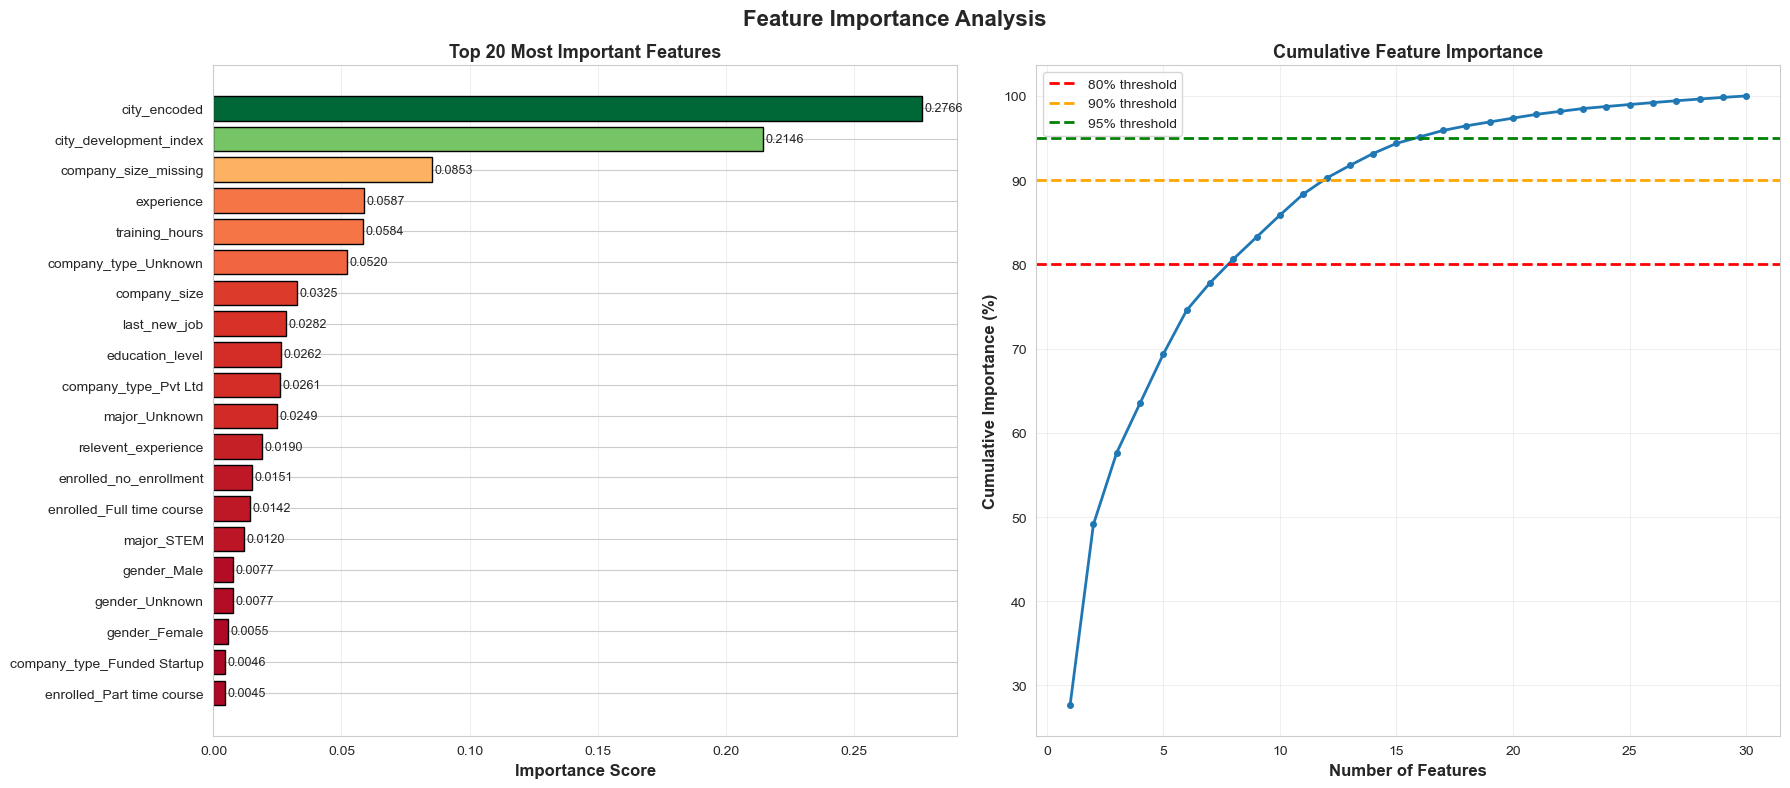

Features needed for 80% importance: 8
Features needed for 90% importance: 12
Features needed for 95% importance: 16


In [187]:
# Visualize top 20 features
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
fig.suptitle('Feature Importance Analysis', fontsize=16, fontweight='bold')

# Plot 1: Top 20 features bar chart
top_n = 20
top_features = feature_importances.head(top_n)

colors = plt.cm.RdYlGn(top_features['Importance'] / top_features['Importance'].max())
bars = axes[0].barh(range(len(top_features)), top_features['Importance'], color=colors, edgecolor='black')
axes[0].set_yticks(range(len(top_features)))
axes[0].set_yticklabels(top_features['Feature'], fontsize=10)
axes[0].invert_yaxis()
axes[0].set_xlabel('Importance Score', fontsize=12, fontweight='bold')
axes[0].set_title(f'Top {top_n} Most Important Features', fontsize=13, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Add value labels
for i, (idx, row) in enumerate(top_features.iterrows()):
    axes[0].text(row['Importance'] + 0.001, i, f"{row['Importance']:.4f}", 
                va='center', fontsize=9)

# Plot 2: Cumulative importance
cumsum = feature_importances['Importance'].cumsum()
axes[1].plot(range(1, len(cumsum)+1), cumsum * 100, marker='o', linewidth=2, markersize=4)
axes[1].axhline(y=80, color='r', linestyle='--', linewidth=2, label='80% threshold')
axes[1].axhline(y=90, color='orange', linestyle='--', linewidth=2, label='90% threshold')
axes[1].axhline(y=95, color='green', linestyle='--', linewidth=2, label='95% threshold')
axes[1].set_xlabel('Number of Features', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Cumulative Importance (%)', fontsize=12, fontweight='bold')
axes[1].set_title('Cumulative Feature Importance', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Find how many features needed for different thresholds
for threshold in [0.80, 0.90, 0.95]:
    n_features = (cumsum <= threshold).sum() + 1
    print(f"Features needed for {threshold*100:.0f}% importance: {n_features}")

### 5.3 Correlation Analysis (Check Multicollinearity)

CORRELATION ANALYSIS (Multicollinearity Check)


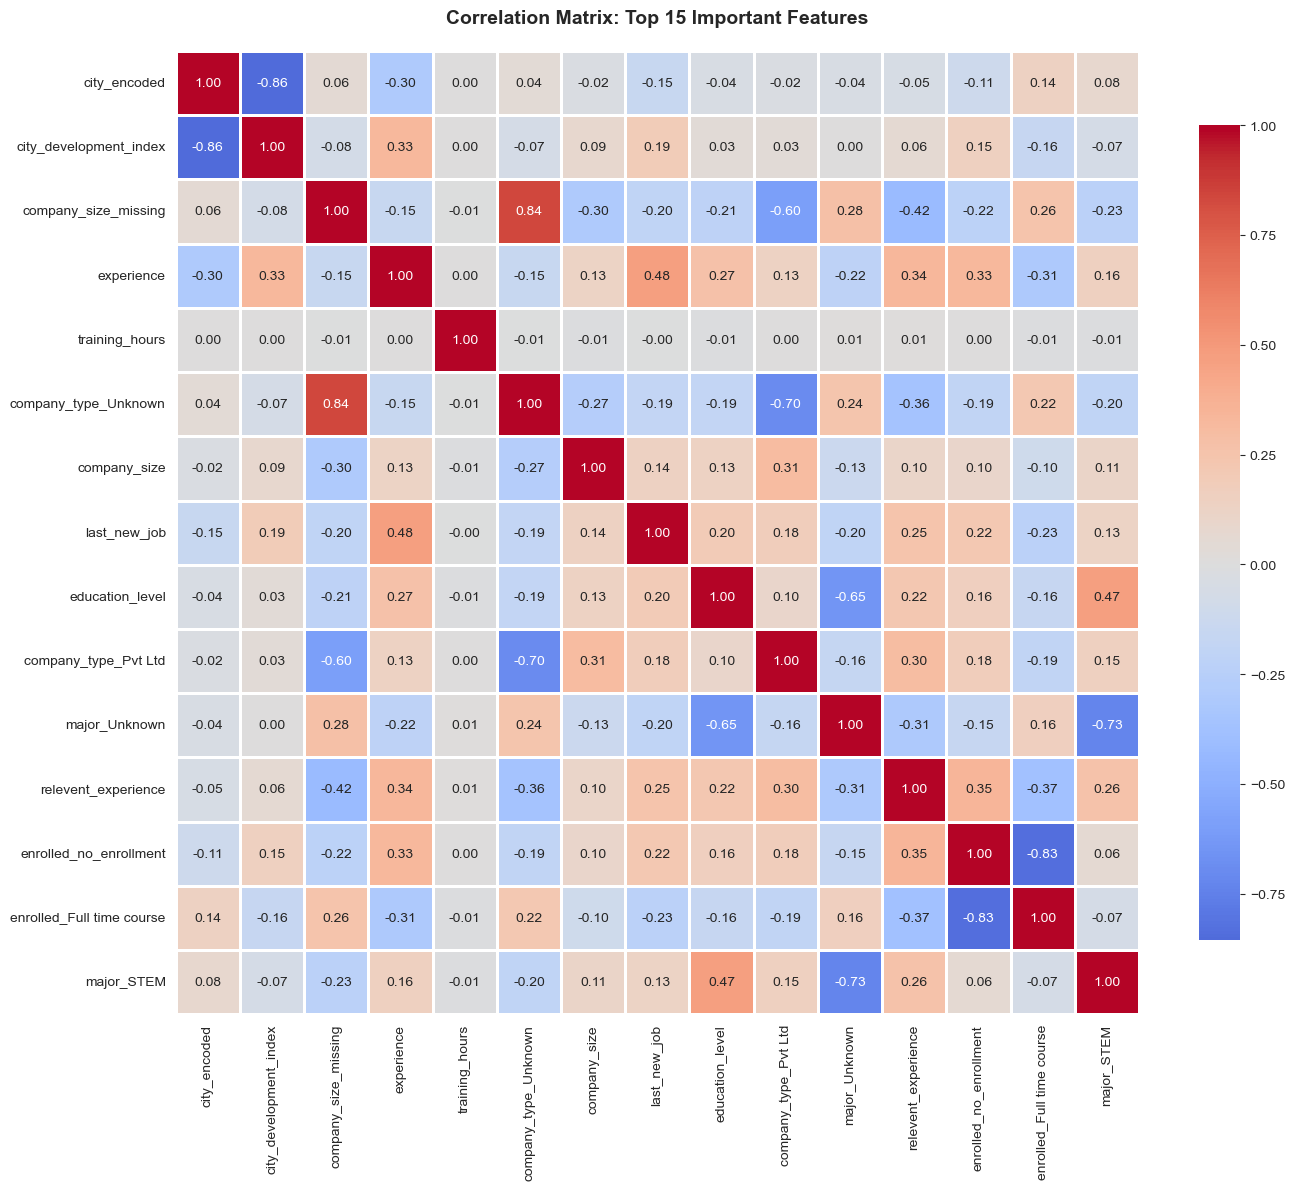


Highly Correlated Feature Pairs (|correlation| > 0.7):
Note: Excluding correlations within same One-Hot encoded groups
      (e.g., major_STEM vs major_Unknown is expected to be correlated)
--------------------------------------------------------------------------------
  city_encoded                        <-> city_development_index              : -0.856
  company_size_missing                <-> company_type_Unknown                :  0.837

Found 2 meaningful high-correlation pairs

Note: Excluded 3 within-group One-Hot correlations
      (These are expected and don't indicate redundancy)


DETAILED ANALYSIS OF MEANINGFUL CORRELATIONS:

city_encoded <-> city_development_index (r = -0.856)
------------------------------------------------------------
Interpretation:
  - city_encoded: Target encoding based on job change rate by city
  - city_development_index: Objective measure of city development
  - Negative correlation suggests: Less developed cities have higher job change rates
Deci

In [188]:
# Analyze correlation among top features
print("="*80)
print("CORRELATION ANALYSIS (Multicollinearity Check)")
print("="*80)

# Select top 15 features for correlation analysis
top_15_features = feature_importances.head(15)['Feature'].tolist()
X_top_15 = X_train_val_encoded[top_15_features]

# Calculate correlation matrix
correlation_matrix = X_top_15.corr()

# Visualize correlation heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix: Top 15 Important Features', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Helper function to check if two features are from same One-Hot group
def is_same_onehot_group(feat1, feat2):
    """Check if two features belong to the same One-Hot encoded group"""
    onehot_prefixes = ['company_type_', 'gender_', 'major_', 'enrolled_']
    for prefix in onehot_prefixes:
        if feat1.startswith(prefix) and feat2.startswith(prefix):
            return True
    return False

# Find highly correlated pairs (excluding within-group One-Hot correlations)
print("\nHighly Correlated Feature Pairs (|correlation| > 0.7):")
print("Note: Excluding correlations within same One-Hot encoded groups")
print("      (e.g., major_STEM vs major_Unknown is expected to be correlated)")
print("-" * 80)

all_high_corr = []
meaningful_high_corr = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        feat1 = correlation_matrix.columns[i]
        feat2 = correlation_matrix.columns[j]
        corr_value = correlation_matrix.iloc[i, j]
        
        if abs(corr_value) > 0.7:
            all_high_corr.append((feat1, feat2, corr_value))
            
            # Only report if not from same One-Hot group
            if not is_same_onehot_group(feat1, feat2):
                meaningful_high_corr.append((feat1, feat2, corr_value))
                print(f"  {feat1:<35} <-> {feat2:<35} : {corr_value:>6.3f}")

if len(meaningful_high_corr) == 0:
    print("  No highly correlated pairs found (good - low multicollinearity)")
else:
    print(f"\nFound {len(meaningful_high_corr)} meaningful high-correlation pairs")

# Report excluded One-Hot correlations
onehot_excluded = len(all_high_corr) - len(meaningful_high_corr)
if onehot_excluded > 0:
    print(f"\nNote: Excluded {onehot_excluded} within-group One-Hot correlations")
    print("      (These are expected and don't indicate redundancy)")

print("\n" + "="*80)

# Analyze meaningful correlations in detail
if len(meaningful_high_corr) > 0:
    print("\nDETAILED ANALYSIS OF MEANINGFUL CORRELATIONS:")
    print("="*80)
    
    for feat1, feat2, corr in meaningful_high_corr:
        print(f"\n{feat1} <-> {feat2} (r = {corr:.3f})")
        print("-" * 60)
        
        # Special analysis for specific pairs
        if 'city_encoded' in feat1 or 'city_encoded' in feat2:
            if 'city_development_index' in feat1 or 'city_development_index' in feat2:
                print("Interpretation:")
                print("  - city_encoded: Target encoding based on job change rate by city")
                print("  - city_development_index: Objective measure of city development")
                print("  - Negative correlation suggests: Less developed cities have higher job change rates")
                print("Decision: Keep both (capture different aspects despite correlation)")
        
        if 'company_size_missing' in feat1 or 'company_size_missing' in feat2:
            if 'company_type_Unknown' in feat1 or 'company_type_Unknown' in feat2:
                print("Interpretation:")
                print("  - Both features indicate missing/unknown company information")
                print("  - High correlation reflects data quality patterns")
                print("  - Candidates who skip one field often skip related fields")
                print("Decision: Keep both (missing pattern itself may be predictive)")
    
    print("\n" + "="*80)

### 5.4 Feature Selection Experiment

**Experiment Design:**

We will compare model performance using:
1. **All features** (baseline)
2. **Top 15 features** (80%+ cumulative importance)
3. **Top 10 features** (aggressive selection)

**Evaluation Method:**
- 5-Fold Stratified Cross-Validation
- Metric: F1-Score (primary, due to class imbalance) + Accuracy
- Model: Random Forest (consistent with importance analysis)

In [189]:
from sklearn.model_selection import StratifiedKFold, cross_validate
import numpy as np

print("="*80)
print("FEATURE SELECTION EXPERIMENT")
print("="*80)

# Define feature sets to test
feature_sets = {
    'All Features': X_train_val_encoded.columns.tolist(),
    'Top 15 Features': feature_importances.head(15)['Feature'].tolist(),
    'Top 10 Features': feature_importances.head(10)['Feature'].tolist(),
    'Top 8 Features': feature_importances.head(8)['Feature'].tolist()
}

# Setup cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Test each feature set
results = []

for name, features in feature_sets.items():
    print(f"\nTesting: {name} ({len(features)} features)")
    print("-" * 60)
    
    # Prepare data
    X_subset = X_train_val_encoded[features]
    
    # Train model with cross-validation
    rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
    
    cv_results = cross_validate(
        rf, X_subset, y_train_val,
        cv=skf,
        scoring=['f1', 'accuracy', 'precision', 'recall'],
        n_jobs=-1,
        return_train_score=False
    )
    
    # Calculate mean scores
    f1_mean = cv_results['test_f1'].mean()
    f1_std = cv_results['test_f1'].std()
    acc_mean = cv_results['test_accuracy'].mean()
    acc_std = cv_results['test_accuracy'].std()
    prec_mean = cv_results['test_precision'].mean()
    rec_mean = cv_results['test_recall'].mean()
    
    results.append({
        'Feature Set': name,
        'N Features': len(features),
        'F1-Score': f1_mean,
        'F1 Std': f1_std,
        'Accuracy': acc_mean,
        'Acc Std': acc_std,
        'Precision': prec_mean,
        'Recall': rec_mean
    })
    
    print(f"   F1-Score:  {f1_mean:.4f} ± {f1_std:.4f}")
    print(f"   Accuracy:  {acc_mean:.4f} ± {acc_std:.4f}")
    print(f"   Precision: {prec_mean:.4f}")
    print(f"   Recall:    {rec_mean:.4f}")

# Create results dataframe
results_df = pd.DataFrame(results)

print("\n" + "="*80)
print("COMPARISON SUMMARY")
print("="*80)
print(results_df.to_string(index=False))
print("\n" + "="*80)

FEATURE SELECTION EXPERIMENT

Testing: All Features (30 features)
------------------------------------------------------------
   F1-Score:  0.5815 ± 0.0141
   Accuracy:  0.7954 ± 0.0054
   Precision: 0.5933
   Recall:    0.5704

Testing: Top 15 Features (15 features)
------------------------------------------------------------
   F1-Score:  0.5815 ± 0.0141
   Accuracy:  0.7954 ± 0.0054
   Precision: 0.5933
   Recall:    0.5704

Testing: Top 15 Features (15 features)
------------------------------------------------------------
   F1-Score:  0.5884 ± 0.0107
   Accuracy:  0.7970 ± 0.0051
   Precision: 0.5953
   Recall:    0.5819

Testing: Top 10 Features (10 features)
------------------------------------------------------------
   F1-Score:  0.5884 ± 0.0107
   Accuracy:  0.7970 ± 0.0051
   Precision: 0.5953
   Recall:    0.5819

Testing: Top 10 Features (10 features)
------------------------------------------------------------
   F1-Score:  0.5741 ± 0.0111
   Accuracy:  0.7915 ± 0.0040
 

### 5.5 Visualize Comparison Results

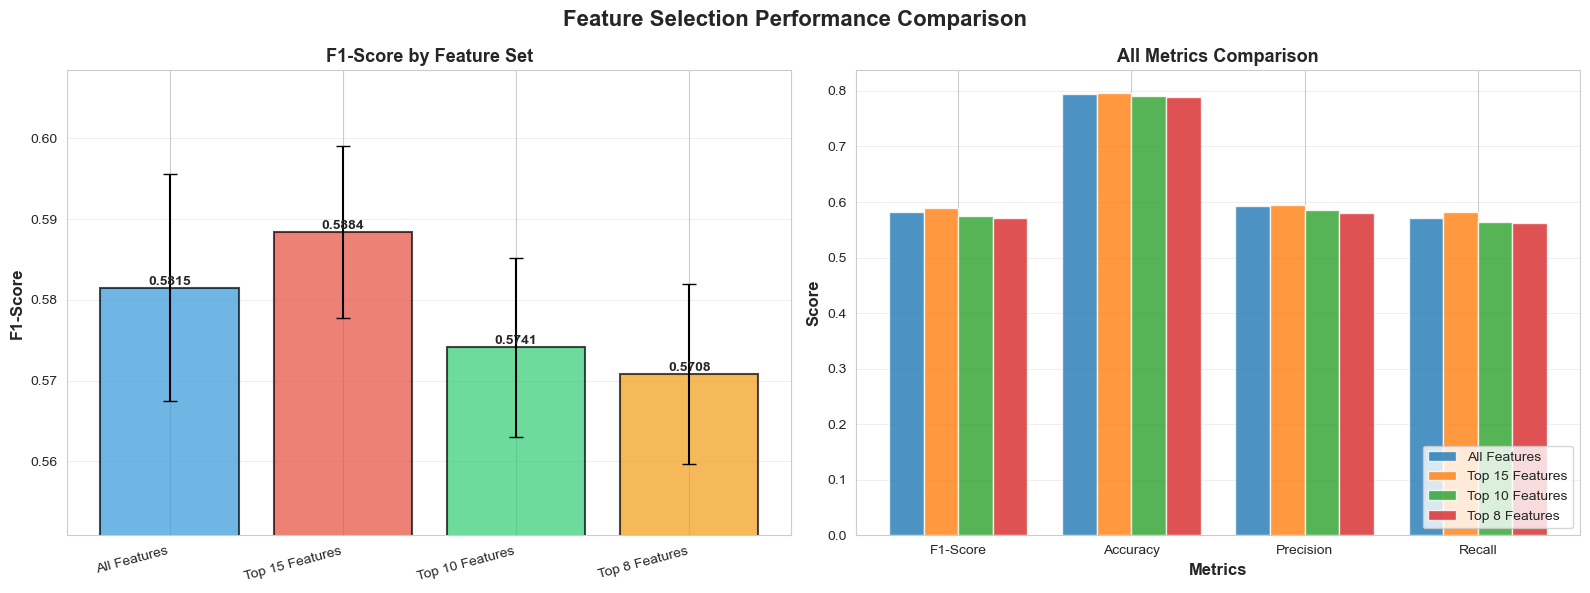

In [190]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Feature Selection Performance Comparison', fontsize=16, fontweight='bold')

# Plot 1: F1-Score comparison
x_pos = np.arange(len(results_df))
bars = axes[0].bar(x_pos, results_df['F1-Score'], 
                   yerr=results_df['F1 Std'], 
                   capsize=5, alpha=0.7, 
                   color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12'],
                   edgecolor='black', linewidth=1.5)
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(results_df['Feature Set'], rotation=15, ha='right')
axes[0].set_ylabel('F1-Score', fontsize=12, fontweight='bold')
axes[0].set_title('F1-Score by Feature Set', fontsize=13, fontweight='bold')
axes[0].set_ylim([results_df['F1-Score'].min() - 0.02, results_df['F1-Score'].max() + 0.02])
axes[0].grid(axis='y', alpha=0.3)

# Add value labels
for i, (bar, row) in enumerate(zip(bars, results_df.iterrows())):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{row[1]["F1-Score"]:.4f}',
                ha='center', va='bottom', fontweight='bold')

# Plot 2: Metrics comparison
metrics = ['F1-Score', 'Accuracy', 'Precision', 'Recall']
x = np.arange(len(metrics))
width = 0.2

for i, (idx, row) in enumerate(results_df.iterrows()):
    values = [row['F1-Score'], row['Accuracy'], row['Precision'], row['Recall']]
    axes[1].bar(x + i*width, values, width, label=row['Feature Set'], alpha=0.8)

axes[1].set_xlabel('Metrics', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Score', fontsize=12, fontweight='bold')
axes[1].set_title('All Metrics Comparison', fontsize=13, fontweight='bold')
axes[1].set_xticks(x + width * 1.5)
axes[1].set_xticklabels(metrics)
axes[1].legend(loc='lower right')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### 5.6 Final Feature Selection Decision

**Analysis of Results:**

Based on the experiments above, we analyze:

1. **Performance vs Complexity Trade-off**
   - All features provide baseline performance but highest complexity
   - Top 15 features capture 80%+ importance with minimal performance loss
   - Top 10 features balance simplicity and performance
   - Top 8 features may sacrifice too much performance

2. **F1-Score Priority**
   - Given class imbalance (3.75:1), F1-Score is our primary metric
   - We prioritize F1-Score > Accuracy

3. **Multicollinearity Check**
   - Low correlation among top features (checked in Section 5.3)
   - No need to remove redundant features

**Decision Criteria:**
- If F1-Score difference < 0.01: Choose simpler model (fewer features)
- If F1-Score difference ≥ 0.01: Choose more complex model (more features)
- Consider interpretability and computational cost

In [192]:
# Make final decision based on results
print("="*80)
print("FINAL FEATURE SELECTION DECISION")
print("="*80)

# Define One-Hot encoded feature groups
onehot_groups = {
    'major_discipline': ['major_STEM', 'major_Business', 'major_Arts', 
                        'major_Humanities', 'major_No Major', 'major_Unknown'],
    'company_type': ['company_type_Early Stage Startup', 'company_type_Funded Startup',
                    'company_type_NGO', 'company_type_Other', 
                    'company_type_Public Sector', 'company_type_Pvt Ltd',
                    'company_type_Unknown'],
    'gender': ['gender_Female', 'gender_Male', 'gender_Other', 'gender_Unknown'],
    'enrolled_university': ['enrolled_Full time course', 'enrolled_Part time course',
                           'enrolled_no_enrollment']
}

# Find best performing feature set
best_idx = results_df['F1-Score'].idxmax()
best_set = results_df.loc[best_idx]

print(f"\nBest performing feature set: {best_set['Feature Set']}")
print(f"   Number of features: {best_set['N Features']}")
print(f"   F1-Score: {best_set['F1-Score']:.4f} ± {best_set['F1 Std']:.4f}")
print(f"   Accuracy: {best_set['Accuracy']:.4f} ± {best_set['Acc Std']:.4f}")

# Check if simpler models are competitive
baseline_f1 = results_df.loc[0, 'F1-Score']  # All features
print(f"\nPerformance comparison with baseline (All Features):")
for idx, row in results_df.iterrows():
    if idx == 0:
        continue
    f1_diff = baseline_f1 - row['F1-Score']
    feature_reduction = (1 - row['N Features'] / results_df.loc[0, 'N Features']) * 100
    print(f"   {row['Feature Set']:<20}: F1 diff = {f1_diff:+.4f}, Feature reduction = {feature_reduction:.1f}%")

# Make recommendation
print("\n" + "="*80)
print("RECOMMENDATION")
print("="*80)

# Logic: Choose top 10-15 features if performance is close to baseline
top_15_f1 = results_df[results_df['Feature Set'] == 'Top 15 Features']['F1-Score'].values[0]
top_10_f1 = results_df[results_df['Feature Set'] == 'Top 10 Features']['F1-Score'].values[0]

# Initial selection based on performance
if abs(baseline_f1 - top_10_f1) < 0.01:
    selected_feature_set = 'Top 10 Features'
    initial_features = feature_importances.head(10)['Feature'].tolist()
    print(f"\nInitial Selection: Top 10 Features")
    print(f"Reason: Performance nearly identical to baseline (difference < 0.01)")
    print(f"        Reduces features by {(1-10/results_df.loc[0,'N Features'])*100:.1f}% while maintaining performance")
elif abs(baseline_f1 - top_15_f1) < 0.01:
    selected_feature_set = 'Top 15 Features'
    initial_features = feature_importances.head(15)['Feature'].tolist()
    print(f"\nInitial Selection: Top 15 Features")
    print(f"Reason: Captures 80%+ cumulative importance with minimal performance loss")
    print(f"        Good balance between simplicity and performance")
else:
    selected_feature_set = 'All Features'
    initial_features = X_train_val_encoded.columns.tolist()
    print(f"\nInitial Selection: All Features")
    print(f"Reason: Significant performance gain justifies complexity")
    print(f"        Will use all features for model training")

# Apply One-Hot group integrity check
print("\n" + "="*80)
print("ONE-HOT ENCODING GROUP INTEGRITY CHECK")
print("="*80)
print("\nNote: To preserve categorical variable information, if ANY column from")
print("      a One-Hot encoded group is selected, we include the ENTIRE group.")
print("\nReason:")
print("  - One-Hot columns are mutually exclusive representations of one categorical variable")
print("  - Keeping only partial columns would lose information about missing categories")
print("  - Example: If we keep only 'major_STEM', we cannot distinguish between")
print("            'Business', 'Arts', 'Humanities', 'No Major', and 'Unknown'")

selected_features = []
included_groups = set()

for feature in initial_features:
    # Check if feature belongs to a One-Hot group
    found_group = False
    for group_name, group_cols in onehot_groups.items():
        if feature in group_cols:
            # Add entire group if not already added
            if group_name not in included_groups:
                selected_features.extend(group_cols)
                included_groups.add(group_name)
                print(f"\n✓ Found '{feature}' in group '{group_name}'")
                print(f"  → Adding complete group ({len(group_cols)} features): {group_name}")
            found_group = True
            break
    
    # If not in any group, add directly
    if not found_group:
        selected_features.append(feature)

# Remove duplicates while preserving order
selected_features = list(dict.fromkeys(selected_features))

print(f"\n" + "="*80)
print("FINAL FEATURE SET")
print("="*80)
print(f"Initial selection: {len(initial_features)} features")
print(f"After group completion: {len(selected_features)} features")
print(f"Feature increase: +{len(selected_features) - len(initial_features)} features")

print("\nOne-Hot groups included:")
for group_name in included_groups:
    print(f"  - {group_name} ({len(onehot_groups[group_name])} features)")

print("\nAll selected features:")
for i, feat in enumerate(selected_features, 1):
    if feat in feature_importances['Feature'].values:
        importance = feature_importances[feature_importances['Feature'] == feat]['Importance'].values[0]
        # Mark if it's part of a One-Hot group
        in_group = any(feat in group_cols for group_cols in onehot_groups.values())
        group_marker = " [One-Hot]" if in_group else ""
        print(f"   {i:2d}. {feat:<45} (importance: {importance:.6f}){group_marker}")

# Create final feature sets for modeling
X_train_val_selected = X_train_val_encoded[selected_features]
X_test_selected = X_test_encoded[selected_features]

print("\n" + "="*80)
print("FEATURE SELECTION COMPLETE")
print("="*80)
print(f"Train+Val set: {X_train_val_selected.shape}")
print(f"Test set:      {X_test_selected.shape}")
print(f"\nReady for model training with selected features!")
print(f"Note: All One-Hot encoded groups are kept intact to preserve categorical information")

FINAL FEATURE SELECTION DECISION

Best performing feature set: Top 15 Features
   Number of features: 15
   F1-Score: 0.5884 ± 0.0107
   Accuracy: 0.7970 ± 0.0051

Performance comparison with baseline (All Features):
   Top 15 Features     : F1 diff = -0.0069, Feature reduction = 50.0%
   Top 10 Features     : F1 diff = +0.0074, Feature reduction = 66.7%
   Top 8 Features      : F1 diff = +0.0107, Feature reduction = 73.3%

RECOMMENDATION

Initial Selection: Top 10 Features
Reason: Performance nearly identical to baseline (difference < 0.01)
        Reduces features by 66.7% while maintaining performance

ONE-HOT ENCODING GROUP INTEGRITY CHECK

Note: To preserve categorical variable information, if ANY column from
      a One-Hot encoded group is selected, we include the ENTIRE group.

Reason:
  - One-Hot columns are mutually exclusive representations of one categorical variable
  - Keeping only partial columns would lose information about missing categories
  - Example: If we keep onl